# Lab 2: Improving the training pipeline

# Training SimpleNN on CIFAR-10
In this project, you will use the SimpleNN model to perform image classification on CIFAR-10. CIFAR-10 orginally contains 60K images from 10 categories. We split it into 45K/5K/10K images to serve as train/valiation/test set. We only release the ground-truth labels of training/validation dataset to you.

In Lab (1), we develop a simplified training pipeline. To obtain better training result, we will improve the training pipeline by employing data augmentation, improving the model design, and tuning the hyperpa- rameters.

Before start, please duplicate the notebook in Lab (1) and name it as simplenn-cifar10-dev.ipynb, and work on the new notebook. You goal is to reach at least 70% validation accuracy on the CIFAR-10 dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys
sys.path.append('/content/drive/MyDrive/2023 - Duke/2025-01/ECE661_ComputerEngineeringMachineLearning&DeepNeuralNets/Assigments/HW2')


Mounted at /content/drive


In [2]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import matplotlib.pyplot as plt

def plot_metrics(EPOCHS, train_losses, val_losses, train_accuracies, val_accuracies, title=None):
    best_val_accuracy = max(val_accuracies)
    best_val_loss = min(val_losses)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    ax1.plot(range(EPOCHS), train_losses, label='Training Loss', color='red')
    ax1.plot(range(EPOCHS), val_losses, label='Validation Loss', color='orange')
    ax1.set_title(f'Training vs Validation Loss\nBest Validation Loss: {best_val_loss:.4f}')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(range(EPOCHS), train_accuracies, label='Training Accuracy', color='blue')
    ax2.plot(range(EPOCHS), val_accuracies, label='Validation Accuracy', color='green')
    ax2.set_title(f'Training vs Validation Accuracy\nBest Validation Accuracy: {best_val_accuracy:.4f}')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    if title:
        fig.suptitle(title, fontsize=16, y=1.05)

    plt.tight_layout()
    plt.show()


In [4]:
#############################################
# GPU check
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")
#############################################

Run on GPU...


# (a) Data Augmentation

## (a)       (6 pts) Data augmentation techniques help combat overfitting. A typical strategy for CIFAR classifica- tion is to combine 1) random cropping with a padding of 4 and 2) random flipping. Train a model with such augmentation. How is the validation accuracy compared with the one without augmentation? Note that in the following questions we all use augmentation. Also remember to reinitialize the model whenever you start a new training!


In [5]:
# useful libraries
import torchvision
import torchvision.transforms as transforms

#############################################
# your code here
# specify preprocessing function
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))])
#############################################

In [6]:
# do NOT change these
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

#############################################
# your code here
# construct dataset
train_set = CIFAR10(
    root=DATA_ROOT,
    mode='train',
    download=True,
    transform=transform_train
)
val_set = CIFAR10(
    root=DATA_ROOT,
    mode='val',
    download=True,
    transform=transform_val
)

# construct dataloader
train_loader = DataLoader(
    train_set,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=4
)
val_loader = DataLoader(
    val_set,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    num_workers=4
)
#############################################

141746176it [00:08, 17686611.61it/s]                               


Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified


In [8]:
import torch.nn as nn
import torch.optim as optim

# SimpleNN mode;
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Model Definition
net = SimpleNN()
net = net.to(device)

# initial learning rate
INITIAL_LR = 0.01

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(
    net.parameters(),
    lr=INITIAL_LR,
    momentum=MOMENTUM,
    weight_decay=REG
)

# some hyperparameters
# total number of training epochs
EPOCHS = 30
DECAY_EPOCHS = 10
DECAY = 1 # without decay

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# Lists to store accuracy values
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    #######################
    # your code here
    # switch to train mode
    net.train()
    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        train_loss += loss.item()

        # count the number of correctly predicted samples in the current batch
        max_values, predicted = outputs.max(1)
        total_examples += targets.size(0)
        correct_examples += (predicted == targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_accuracies.append(avg_acc)
    train_losses.append(avg_loss)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" % current_learning_rate)


    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

            # count the number of correctly predicted samples in the current batch
            max_values, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += (predicted == targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    val_accuracies.append(avg_acc)
    val_losses.append(avg_loss)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")
        #state = {'state_dict': net.state_dict(),
        #         'epoch': i,
        #         'lr': current_learning_rate}
        #torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 1.9271, Training accuracy: 0.2840
Validation loss: 1.6051, Validation accuracy: 0.4136

Epoch 1:
Training loss: 1.5770, Training accuracy: 0.4211
Validation loss: 1.4353, Validation accuracy: 0.4680

Epoch 2:
Training loss: 1.4373, Training accuracy: 0.4786
Validation loss: 1.2889, Validation accuracy: 0.5404

Epoch 3:
Training loss: 1.3449, Training accuracy: 0.5170
Validation loss: 1.2403, Validation accuracy: 0.5576

Epoch 4:
Training loss: 1.2777, Training accuracy: 0.5402
Validation loss: 1.1704, Validation accuracy: 0.5876

Epoch 5:
Training loss: 1.2327, Training accuracy: 0.5619
Validation loss: 1.2070, Validation accuracy: 0.5700

Epoch 6:
Training loss: 1.1798, Training accuracy: 0.5830
Validation loss: 1.0969, Validation accuracy: 0.6096

Epoch 7:
Training loss: 1.1415, Training accuracy: 0.5968
Validation loss: 1.0604, Validation accuracy: 0.6274

Epoch 8:
Training loss: 1.1241, Training accuracy: 0.6019
Validation loss: 1.0420, 

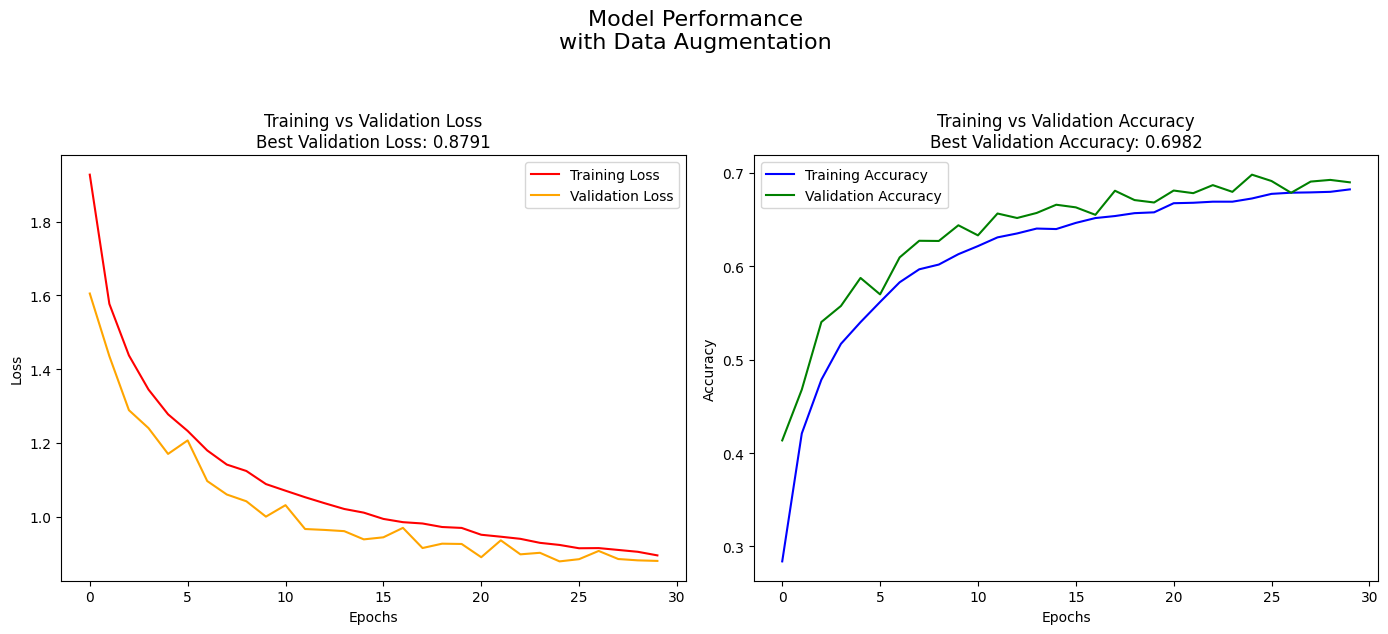

In [9]:
plot_metrics(EPOCHS, train_losses, val_losses, train_accuracies, val_accuracies,
             title=f"Model Performance\nwith Data Augmentation")


# (b)	Model Design

(b)	(15 pts) Model design is another important factor in determining performance on a given task. Now, modify the design of SimpleNN as instructed below:
i.	(5 pts) Add a batch normalization (BN) layer after each convolution layer. Compared with no BN layers, how does the best validation accuracy change?
ii.	(5 pts) Use empirical results to show that batch normalization allows a larger learning rate.
iii.	(5 pts) Implement Swish [2] activation on you own, and replace all of the ReLU activations in SimpleNN to Swish. Train the model with BN layers and a learning rate of 0.1. Does Swish outperform ReLU?


i.	(5 pts) Add a batch normalization (BN) layer after each convolution layer. Compared with no BN layers, how does the best validation accuracy change?

In [10]:
# SimpleNN mode;
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Model Definition
net = SimpleNN()
net = net.to(device)

# initial learning rate
INITIAL_LR = 0.01

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(
    net.parameters(),
    lr=INITIAL_LR,
    momentum=MOMENTUM,
    weight_decay=REG
)

# some hyperparameters
# total number of training epochs
EPOCHS = 30
DECAY_EPOCHS = 10
DECAY = 1 # without decay

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# Lists to store accuracy values
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    #######################
    # your code here
    # switch to train mode
    net.train()
    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        train_loss += loss.item()

        # count the number of correctly predicted samples in the current batch
        max_values, predicted = outputs.max(1)
        total_examples += targets.size(0)
        correct_examples += (predicted == targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_accuracies.append(avg_acc)
    train_losses.append(avg_loss)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" % current_learning_rate)


    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

            # count the number of correctly predicted samples in the current batch
            max_values, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += (predicted == targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    val_accuracies.append(avg_acc)
    val_losses.append(avg_loss)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")
        #state = {'state_dict': net.state_dict(),
        #         'epoch': i,
        #         'lr': current_learning_rate}
        #torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 1.7457, Training accuracy: 0.3503
Validation loss: 1.4375, Validation accuracy: 0.4768

Epoch 1:
Training loss: 1.4358, Training accuracy: 0.4741
Validation loss: 1.2609, Validation accuracy: 0.5462

Epoch 2:
Training loss: 1.3308, Training accuracy: 0.5185
Validation loss: 1.1886, Validation accuracy: 0.5778

Epoch 3:
Training loss: 1.2326, Training accuracy: 0.5569
Validation loss: 1.3100, Validation accuracy: 0.5388

Epoch 4:
Training loss: 1.1829, Training accuracy: 0.5776
Validation loss: 1.1272, Validation accuracy: 0.6026

Epoch 5:
Training loss: 1.1463, Training accuracy: 0.5951
Validation loss: 1.0678, Validation accuracy: 0.6238

Epoch 6:
Training loss: 1.1022, Training accuracy: 0.6102
Validation loss: 1.0259, Validation accuracy: 0.6356

Epoch 7:
Training loss: 1.0610, Training accuracy: 0.6241
Validation loss: 1.0537, Validation accuracy: 0.6314

Epoch 8:
Training loss: 1.0491, Training accuracy: 0.6253
Validation loss: 1.0055, 

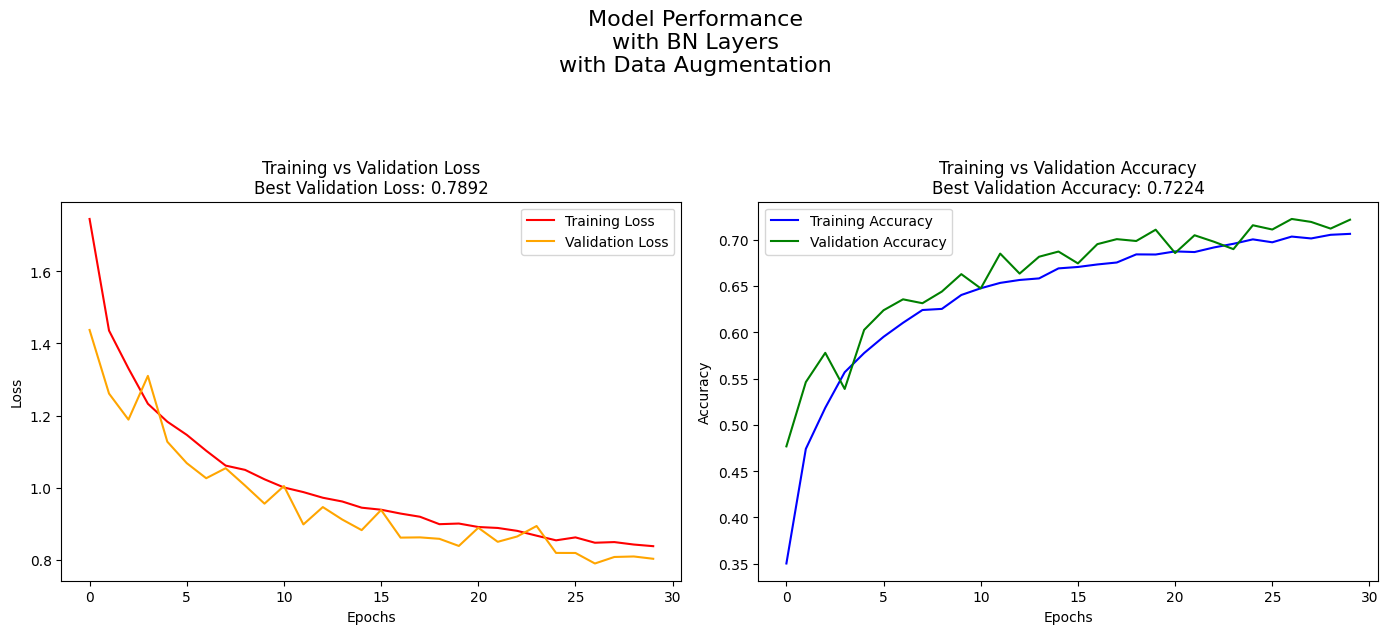

In [11]:
plot_metrics(EPOCHS, train_losses, val_losses, train_accuracies, val_accuracies,
             title=f"Model Performance\nwith BN Layers\nwith Data Augmentation\n")

ii.	(5 pts) Use empirical results to show that batch normalization allows a larger learning rate.

Let's compare how Batch Normalization (BN) affects the use of higher learning rates by training
four versions of our CNN:

1. CNN with Batch Normalization, learning rate = 0.01
2. CNN with Batch Normalization, learning rate = 0.1
3. CNN without Batch Normalization, learning rate = 0.01
4. CNN without Batch Normalization, learning rate = 0.1

In [12]:
# 1. CNN with Batch Normalization, learning rate = 0.01
# SimpleNN mode;
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Model Definition
net = SimpleNN()
net = net.to(device)

# initial learning rate
INITIAL_LR = 0.01

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(
    net.parameters(),
    lr=INITIAL_LR,
    momentum=MOMENTUM,
    weight_decay=REG
)

# some hyperparameters
# total number of training epochs
EPOCHS = 30
DECAY_EPOCHS = 10
DECAY = 1 # without decay

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# Lists to store accuracy values
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc_bn_lr001 = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    #######################
    # your code here
    # switch to train mode
    net.train()
    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        train_loss += loss.item()

        # count the number of correctly predicted samples in the current batch
        max_values, predicted = outputs.max(1)
        total_examples += targets.size(0)
        correct_examples += (predicted == targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_accuracies.append(avg_acc)
    train_losses.append(avg_loss)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" % current_learning_rate)


    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

            # count the number of correctly predicted samples in the current batch
            max_values, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += (predicted == targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    val_accuracies.append(avg_acc)
    val_losses.append(avg_loss)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc_bn_lr001:
        best_val_acc_bn_lr001 = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")
        #state = {'state_dict': net.state_dict(),
        #         'epoch': i,
        #         'lr': current_learning_rate}
        #torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc_bn_lr001:.4f}")

==> Training starts!
Epoch 0:
Training loss: 1.7567, Training accuracy: 0.3464
Validation loss: 1.4100, Validation accuracy: 0.4908

Epoch 1:
Training loss: 1.4288, Training accuracy: 0.4770
Validation loss: 1.2922, Validation accuracy: 0.5362

Epoch 2:
Training loss: 1.3089, Training accuracy: 0.5318
Validation loss: 1.2047, Validation accuracy: 0.5714

Epoch 3:
Training loss: 1.2336, Training accuracy: 0.5573
Validation loss: 1.1195, Validation accuracy: 0.6062

Epoch 4:
Training loss: 1.1701, Training accuracy: 0.5854
Validation loss: 1.0698, Validation accuracy: 0.6226

Epoch 5:
Training loss: 1.1361, Training accuracy: 0.5944
Validation loss: 1.0507, Validation accuracy: 0.6300

Epoch 6:
Training loss: 1.0936, Training accuracy: 0.6142
Validation loss: 1.0132, Validation accuracy: 0.6440

Epoch 7:
Training loss: 1.0668, Training accuracy: 0.6206
Validation loss: 1.0000, Validation accuracy: 0.6462

Epoch 8:
Training loss: 1.0440, Training accuracy: 0.6318
Validation loss: 1.0840, 

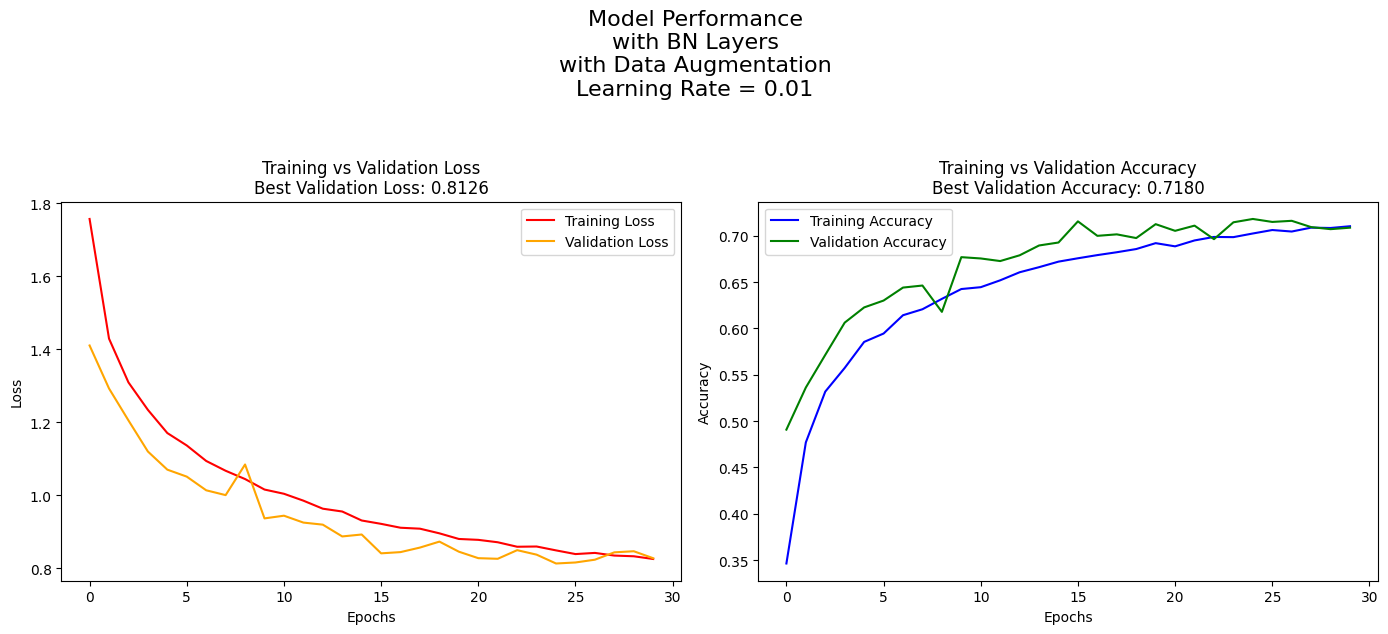

In [13]:
plot_metrics(EPOCHS, train_losses, val_losses, train_accuracies, val_accuracies,
             title=f"Model Performance\nwith BN Layers\nwith Data Augmentation\nLearning Rate = {INITIAL_LR}")


In [14]:
#2. CNN with Batch Normalization, learning rate = 0.1
# SimpleNN mode;
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Model Definition
net = SimpleNN()
net = net.to(device)

# initial learning rate
INITIAL_LR = 0.1

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(
    net.parameters(),
    lr=INITIAL_LR,
    momentum=MOMENTUM,
    weight_decay=REG
)

# some hyperparameters
# total number of training epochs
EPOCHS = 30
DECAY_EPOCHS = 10
DECAY = 1 # without decay

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# Lists to store accuracy values
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc_bn_lr01 = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    #######################
    # your code here
    # switch to train mode
    net.train()
    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        train_loss += loss.item()

        # count the number of correctly predicted samples in the current batch
        max_values, predicted = outputs.max(1)
        total_examples += targets.size(0)
        correct_examples += (predicted == targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_accuracies.append(avg_acc)
    train_losses.append(avg_loss)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" % current_learning_rate)


    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

            # count the number of correctly predicted samples in the current batch
            max_values, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += (predicted == targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    val_accuracies.append(avg_acc)
    val_losses.append(avg_loss)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc_bn_lr01:
        best_val_acc_bn_lr01 = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")
        #state = {'state_dict': net.state_dict(),
        #         'epoch': i,
        #         'lr': current_learning_rate}
        #torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc_bn_lr01:.4f}")

==> Training starts!
Epoch 0:
Training loss: 1.7217, Training accuracy: 0.3608
Validation loss: 1.4646, Validation accuracy: 0.4708

Epoch 1:
Training loss: 1.4517, Training accuracy: 0.4772
Validation loss: 1.3045, Validation accuracy: 0.5316

Epoch 2:
Training loss: 1.3383, Training accuracy: 0.5188
Validation loss: 1.2873, Validation accuracy: 0.5466

Epoch 3:
Training loss: 1.2732, Training accuracy: 0.5472
Validation loss: 1.2563, Validation accuracy: 0.5598

Epoch 4:
Training loss: 1.2261, Training accuracy: 0.5675
Validation loss: 1.1489, Validation accuracy: 0.5900

Epoch 5:
Training loss: 1.1948, Training accuracy: 0.5778
Validation loss: 1.1138, Validation accuracy: 0.6108

Epoch 6:
Training loss: 1.1655, Training accuracy: 0.5898
Validation loss: 1.0739, Validation accuracy: 0.6320

Epoch 7:
Training loss: 1.1483, Training accuracy: 0.5955
Validation loss: 1.1047, Validation accuracy: 0.6156

Epoch 8:
Training loss: 1.1344, Training accuracy: 0.6030
Validation loss: 1.1453, 

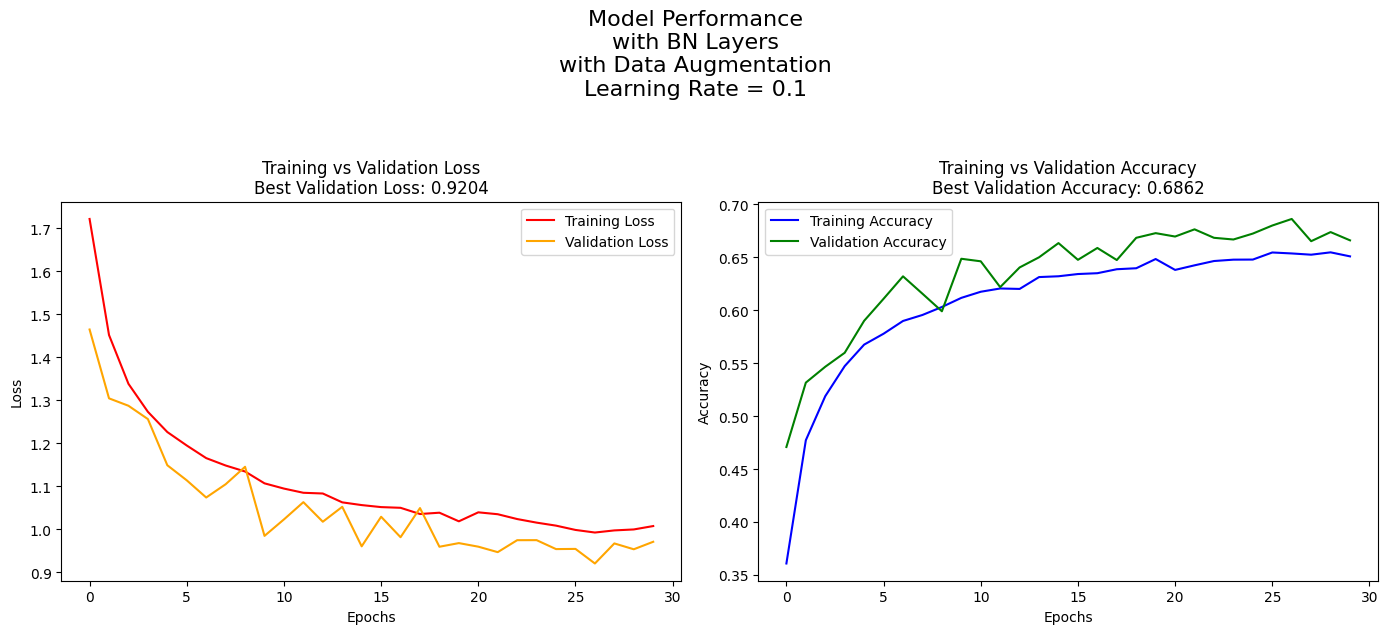

In [15]:
plot_metrics(EPOCHS, train_losses, val_losses, train_accuracies, val_accuracies,
             title=f"Model Performance\nwith BN Layers\nwith Data Augmentation\nLearning Rate = {INITIAL_LR}")

In [16]:
#3. CNN without Batch Normalization, learning rate = 0.01
# SimpleNN mode;
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Model Definition
net = SimpleNN()
net = net.to(device)

# initial learning rate
INITIAL_LR = 0.01

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(
    net.parameters(),
    lr=INITIAL_LR,
    momentum=MOMENTUM,
    weight_decay=REG
)

# some hyperparameters
# total number of training epochs
EPOCHS = 30
DECAY_EPOCHS = 10
DECAY = 1 # without decay

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# Lists to store accuracy values
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc_no_bn_lr001 = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    #######################
    # your code here
    # switch to train mode
    net.train()
    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        train_loss += loss.item()

        # count the number of correctly predicted samples in the current batch
        max_values, predicted = outputs.max(1)
        total_examples += targets.size(0)
        correct_examples += (predicted == targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_accuracies.append(avg_acc)
    train_losses.append(avg_loss)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" % current_learning_rate)


    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

            # count the number of correctly predicted samples in the current batch
            max_values, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += (predicted == targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    val_accuracies.append(avg_acc)
    val_losses.append(avg_loss)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc_no_bn_lr001:
        best_val_acc_no_bn_lr001 = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")
        #state = {'state_dict': net.state_dict(),
        #         'epoch': i,
        #         'lr': current_learning_rate}
        #torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc_no_bn_lr001:.4f}")

==> Training starts!
Epoch 0:
Training loss: 1.8996, Training accuracy: 0.2964
Validation loss: 1.5852, Validation accuracy: 0.4100

Epoch 1:
Training loss: 1.5719, Training accuracy: 0.4234
Validation loss: 1.4532, Validation accuracy: 0.4692

Epoch 2:
Training loss: 1.4358, Training accuracy: 0.4801
Validation loss: 1.3048, Validation accuracy: 0.5390

Epoch 3:
Training loss: 1.3394, Training accuracy: 0.5176
Validation loss: 1.2194, Validation accuracy: 0.5676

Epoch 4:
Training loss: 1.2729, Training accuracy: 0.5457
Validation loss: 1.1889, Validation accuracy: 0.5844

Epoch 5:
Training loss: 1.2212, Training accuracy: 0.5641
Validation loss: 1.1755, Validation accuracy: 0.5852

Epoch 6:
Training loss: 1.1840, Training accuracy: 0.5800
Validation loss: 1.1796, Validation accuracy: 0.5818

Epoch 7:
Training loss: 1.1559, Training accuracy: 0.5913
Validation loss: 1.0945, Validation accuracy: 0.6140

Epoch 8:
Training loss: 1.1135, Training accuracy: 0.6057
Validation loss: 1.1043, 

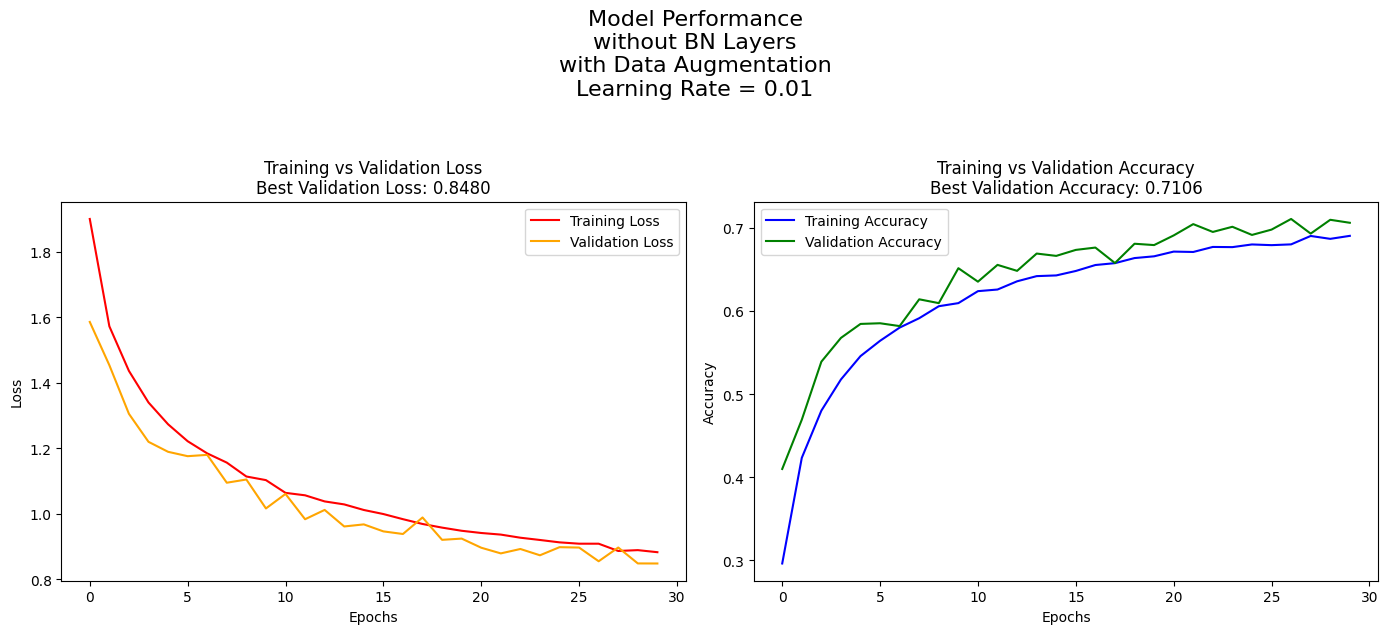

In [17]:
plot_metrics(EPOCHS, train_losses, val_losses, train_accuracies, val_accuracies,
             title=f"Model Performance\nwithout BN Layers\nwith Data Augmentation\nLearning Rate = {INITIAL_LR}")


In [18]:
#4. CNN without Batch Normalization, learning rate = 0.1
# SimpleNN mode;
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Model Definition
net = SimpleNN()
net = net.to(device)

# initial learning rate
INITIAL_LR = 0.1

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(
    net.parameters(),
    lr=INITIAL_LR,
    momentum=MOMENTUM,
    weight_decay=REG
)

# some hyperparameters
# total number of training epochs
EPOCHS = 30
DECAY_EPOCHS = 10
DECAY = 1 # without decay

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# Lists to store accuracy values
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc_no_bn_lr01 = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    #######################
    # your code here
    # switch to train mode
    net.train()
    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        train_loss += loss.item()

        # count the number of correctly predicted samples in the current batch
        max_values, predicted = outputs.max(1)
        total_examples += targets.size(0)
        correct_examples += (predicted == targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_accuracies.append(avg_acc)
    train_losses.append(avg_loss)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" % current_learning_rate)


    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

            # count the number of correctly predicted samples in the current batch
            max_values, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += (predicted == targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    val_accuracies.append(avg_acc)
    val_losses.append(avg_loss)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc_no_bn_lr01:
        best_val_acc_no_bn_lr01 = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")
        #state = {'state_dict': net.state_dict(),
        #         'epoch': i,
        #         'lr': current_learning_rate}
        #torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc_no_bn_lr01:.4f}")

==> Training starts!
Epoch 0:
Training loss: 1.8863, Training accuracy: 0.2946
Validation loss: 1.7259, Validation accuracy: 0.4006

Epoch 1:
Training loss: 1.6910, Training accuracy: 0.3812
Validation loss: 1.5976, Validation accuracy: 0.4364

Epoch 2:
Training loss: 1.6563, Training accuracy: 0.3994
Validation loss: 1.5351, Validation accuracy: 0.4486

Epoch 3:
Training loss: 1.6096, Training accuracy: 0.4183
Validation loss: 1.5349, Validation accuracy: 0.4518

Epoch 4:
Training loss: 1.6230, Training accuracy: 0.4140
Validation loss: 1.5439, Validation accuracy: 0.4532

Epoch 5:
Training loss: 1.6271, Training accuracy: 0.4165
Validation loss: 1.5353, Validation accuracy: 0.4494

Epoch 6:
Training loss: 1.5908, Training accuracy: 0.4331
Validation loss: 1.5056, Validation accuracy: 0.4560

Epoch 7:
Training loss: 1.6114, Training accuracy: 0.4220
Validation loss: 1.5652, Validation accuracy: 0.4534

Epoch 8:
Training loss: 1.5861, Training accuracy: 0.4348
Validation loss: 1.4796, 

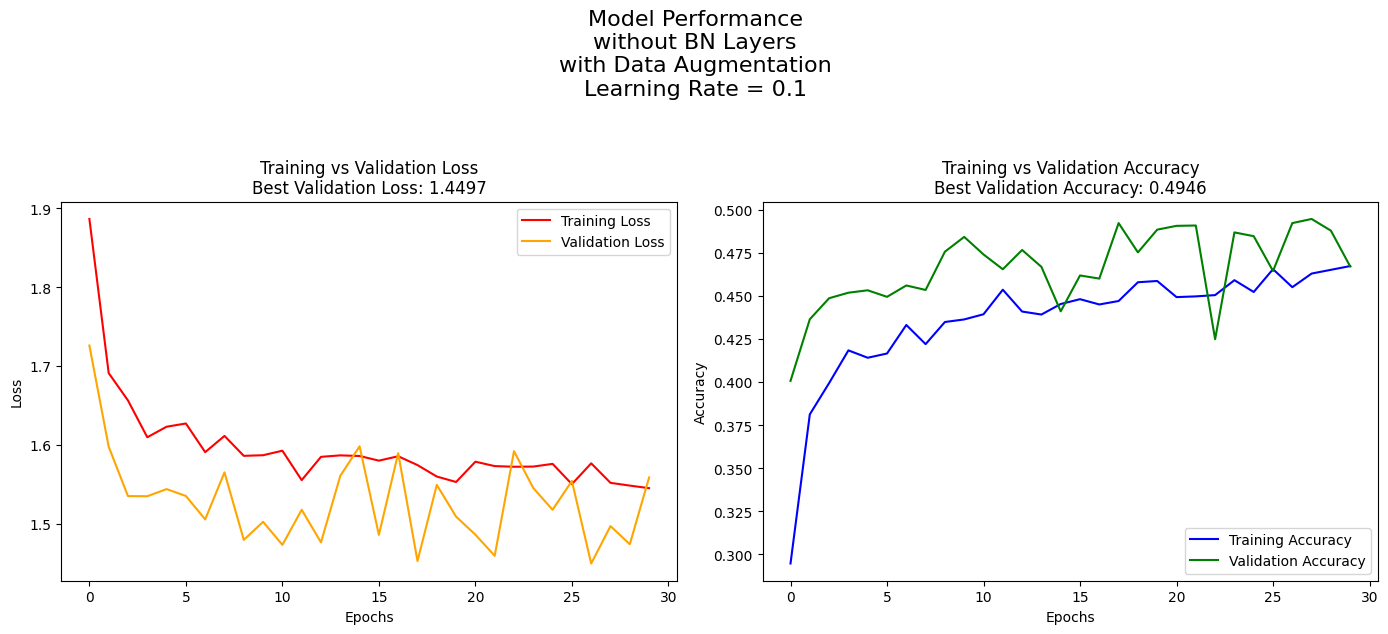

In [19]:
plot_metrics(EPOCHS, train_losses, val_losses, train_accuracies, val_accuracies,
             title=f"Model Performance\nwithout BN Layers\nwith Data Augmentation\nLearning Rate = {INITIAL_LR}")


In [20]:
print("="*50)
print(f"==> Model Comparison:")
print(f"==> Model Comparison:")
print(f"Model 1 (BN, LR=0.01) - Best validation accuracy: {best_val_acc_bn_lr001:.4f}")
print(f"Model 2 (BN, LR=0.1) - Best validation accuracy: {best_val_acc_bn_lr01:.4f}")
print(f"Model 3 (No BN, LR=0.01) - Best validation accuracy: {best_val_acc_no_bn_lr001:.4f}")
print(f"Model 4 (No BN, LR=0.1) - Best validation accuracy: {best_val_acc_no_bn_lr01:.4f}")


==> Model Comparison:
==> Model Comparison:
Model 1 (BN, LR=0.01) - Best validation accuracy: 0.7180
Model 2 (BN, LR=0.1) - Best validation accuracy: 0.6862
Model 3 (No BN, LR=0.01) - Best validation accuracy: 0.7106
Model 4 (No BN, LR=0.1) - Best validation accuracy: 0.4946


iii.	(5 pts) Implement Swish [2] activation on you own, and replace all of the ReLU activations in SimpleNN to Swish. Train the model with BN layers and a learning rate of 0.1. Does Swish outperform ReLU?

In [21]:
def swish(x):
    return x * torch.sigmoid(x)

# SimpleNN mode;
class SimpleNN_Swish(nn.Module):
    def __init__(self):
        super(SimpleNN_Swish, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = swish(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = swish(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = swish(self.fc1(out))
        out = swish(self.fc2(out))
        out = self.fc3(out)
        return out

# Model Definition
net = SimpleNN_Swish()
net = net.to(device)

# initial learning rate
INITIAL_LR = 0.1

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(
    net.parameters(),
    lr=INITIAL_LR,
    momentum=MOMENTUM,
    weight_decay=REG
)

# some hyperparameters
# total number of training epochs
EPOCHS = 30
DECAY_EPOCHS = 10
DECAY = 1 # without decay

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# Lists to store accuracy values
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    #######################
    # your code here
    # switch to train mode
    net.train()
    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        train_loss += loss.item()

        # count the number of correctly predicted samples in the current batch
        max_values, predicted = outputs.max(1)
        total_examples += targets.size(0)
        correct_examples += (predicted == targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_accuracies.append(avg_acc)
    train_losses.append(avg_loss)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" % current_learning_rate)


    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

            # count the number of correctly predicted samples in the current batch
            max_values, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += (predicted == targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    val_accuracies.append(avg_acc)
    val_losses.append(avg_loss)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")
        #state = {'state_dict': net.state_dict(),
        #         'epoch': i,
        #         'lr': current_learning_rate}
        #torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 1.6405, Training accuracy: 0.3942
Validation loss: 1.4696, Validation accuracy: 0.4620

Epoch 1:
Training loss: 1.3387, Training accuracy: 0.5137
Validation loss: 1.1818, Validation accuracy: 0.5678

Epoch 2:
Training loss: 1.2251, Training accuracy: 0.5605
Validation loss: 1.0853, Validation accuracy: 0.6086

Epoch 3:
Training loss: 1.1453, Training accuracy: 0.5917
Validation loss: 1.0282, Validation accuracy: 0.6386

Epoch 4:
Training loss: 1.0872, Training accuracy: 0.6120
Validation loss: 1.0232, Validation accuracy: 0.6350

Epoch 5:
Training loss: 1.0541, Training accuracy: 0.6272
Validation loss: 0.9528, Validation accuracy: 0.6694

Epoch 6:
Training loss: 1.0288, Training accuracy: 0.6370
Validation loss: 0.9390, Validation accuracy: 0.6670

Epoch 7:
Training loss: 0.9930, Training accuracy: 0.6493
Validation loss: 0.9210, Validation accuracy: 0.6766

Epoch 8:
Training loss: 0.9871, Training accuracy: 0.6511
Validation loss: 0.9287, 

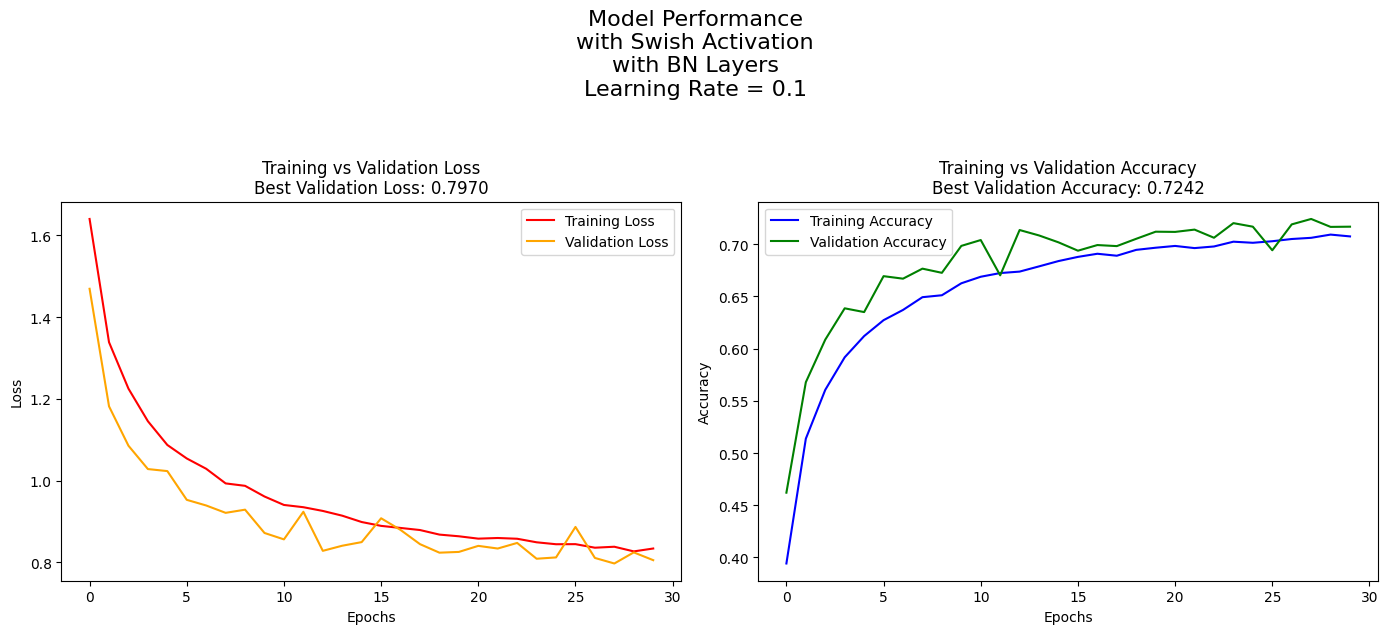

In [22]:
plot_metrics(EPOCHS, train_losses, val_losses, train_accuracies, val_accuracies,
             title=f"Model Performance\nwith Swish Activation\nwith BN Layers\nLearning Rate = {INITIAL_LR}")


# (b) Tuning Hyperparameters

(c)	(14 pts) Hyperparameter settings are very important and can have a large impact on the final model performance. Based on the improvements that you have made to the training pipeline thus far (with data augmentation and BN layers), tune some of the hyperparameters as instructed below:


i.	(7 pts) Apply different learning rate values: 1.0, 0.1, 0.05, 0.01, 0.005, 0.001, to see how the learning rate affects the model performance, and report results for each. Is a large learning rate beneficial for model training? If not, what can you conclude from the choice of learning rate?


In [23]:
# CNN with Batch Normalization and learning rate = 1.0
# SimpleNN mode;
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Model Definition
net = SimpleNN()
net = net.to(device)

# initial learning rate
INITIAL_LR = 1.0

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(
    net.parameters(),
    lr=INITIAL_LR,
    momentum=MOMENTUM,
    weight_decay=REG
)

# some hyperparameters
# total number of training epochs
EPOCHS = 30
DECAY_EPOCHS = 10
DECAY = 1 # without decay

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# Lists to store accuracy values
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    #######################
    # your code here
    # switch to train mode
    net.train()
    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        train_loss += loss.item()

        # count the number of correctly predicted samples in the current batch
        max_values, predicted = outputs.max(1)
        total_examples += targets.size(0)
        correct_examples += (predicted == targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_accuracies.append(avg_acc)
    train_losses.append(avg_loss)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" % current_learning_rate)


    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

            # count the number of correctly predicted samples in the current batch
            max_values, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += (predicted == targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    val_accuracies.append(avg_acc)
    val_losses.append(avg_loss)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")
        #state = {'state_dict': net.state_dict(),
        #         'epoch': i,
        #         'lr': current_learning_rate}
        #torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")


==> Training starts!
Epoch 0:
Training loss: 2.3011, Training accuracy: 0.1264
Validation loss: 2.3168, Validation accuracy: 0.1046

Epoch 1:
Training loss: 2.3213, Training accuracy: 0.1028
Validation loss: 2.3239, Validation accuracy: 0.0980

Epoch 2:
Training loss: 2.3206, Training accuracy: 0.0994
Validation loss: 2.3289, Validation accuracy: 0.0980

Epoch 3:
Training loss: 2.3209, Training accuracy: 0.1000
Validation loss: 2.3165, Validation accuracy: 0.1046

Epoch 4:
Training loss: 2.3197, Training accuracy: 0.1012
Validation loss: 2.3175, Validation accuracy: 0.0986

Epoch 5:
Training loss: 2.3210, Training accuracy: 0.0997
Validation loss: 2.3208, Validation accuracy: 0.0984

Epoch 6:
Training loss: 2.3209, Training accuracy: 0.1003
Validation loss: 2.3282, Validation accuracy: 0.0986

Epoch 7:
Training loss: 2.3222, Training accuracy: 0.1018
Validation loss: 2.3232, Validation accuracy: 0.0978

Epoch 8:
Training loss: 2.3194, Training accuracy: 0.1021
Validation loss: 2.3256, 

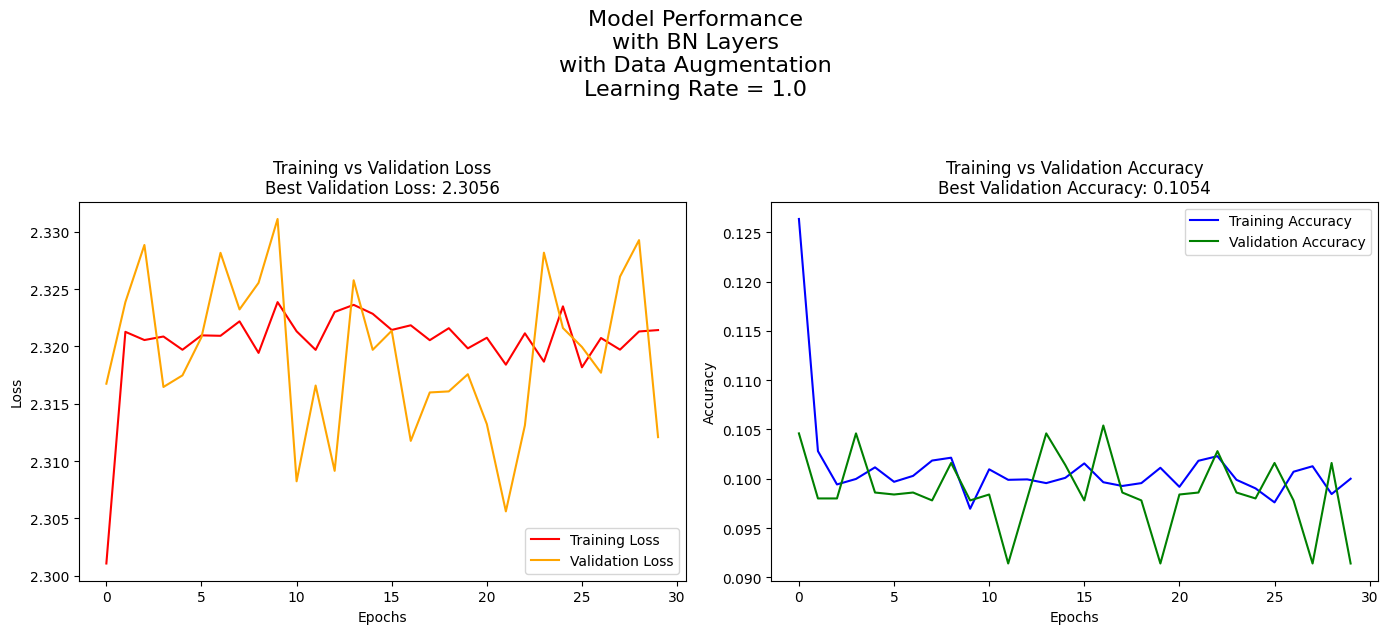

In [24]:
plot_metrics(EPOCHS, train_losses, val_losses, train_accuracies, val_accuracies,
             title=f"Model Performance\nwith BN Layers\nwith Data Augmentation\nLearning Rate = {INITIAL_LR}")

In [25]:
# CNN with Batch Normalization and learning rate = 0.1
# SimpleNN mode;
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Model Definition
net = SimpleNN()
net = net.to(device)

# initial learning rate
INITIAL_LR = 0.1

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(
    net.parameters(),
    lr=INITIAL_LR,
    momentum=MOMENTUM,
    weight_decay=REG
)

# some hyperparameters
# total number of training epochs
EPOCHS = 30
DECAY_EPOCHS = 10
DECAY = 1 # without decay

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# Lists to store accuracy values
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc_bn_lr001 = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    #######################
    # your code here
    # switch to train mode
    net.train()
    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        train_loss += loss.item()

        # count the number of correctly predicted samples in the current batch
        max_values, predicted = outputs.max(1)
        total_examples += targets.size(0)
        correct_examples += (predicted == targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_accuracies.append(avg_acc)
    train_losses.append(avg_loss)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" % current_learning_rate)


    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

            # count the number of correctly predicted samples in the current batch
            max_values, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += (predicted == targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    val_accuracies.append(avg_acc)
    val_losses.append(avg_loss)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")
        #state = {'state_dict': net.state_dict(),
        #         'epoch': i,
        #         'lr': current_learning_rate}
        #torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")


==> Training starts!
Epoch 0:
Training loss: 1.7169, Training accuracy: 0.3608
Validation loss: 1.4835, Validation accuracy: 0.4528

Epoch 1:
Training loss: 1.4907, Training accuracy: 0.4562
Validation loss: 1.3712, Validation accuracy: 0.5120

Epoch 2:
Training loss: 1.3879, Training accuracy: 0.4998
Validation loss: 1.3920, Validation accuracy: 0.5094

Epoch 3:
Training loss: 1.3304, Training accuracy: 0.5272
Validation loss: 1.3116, Validation accuracy: 0.5396

Epoch 4:
Training loss: 1.2749, Training accuracy: 0.5487
Validation loss: 1.2102, Validation accuracy: 0.5796

Epoch 5:
Training loss: 1.2337, Training accuracy: 0.5650
Validation loss: 1.1387, Validation accuracy: 0.6000

Epoch 6:
Training loss: 1.2233, Training accuracy: 0.5693
Validation loss: 1.1505, Validation accuracy: 0.5966

Epoch 7:
Training loss: 1.1901, Training accuracy: 0.5797
Validation loss: 1.0954, Validation accuracy: 0.6162

Epoch 8:
Training loss: 1.1807, Training accuracy: 0.5836
Validation loss: 1.0879, 

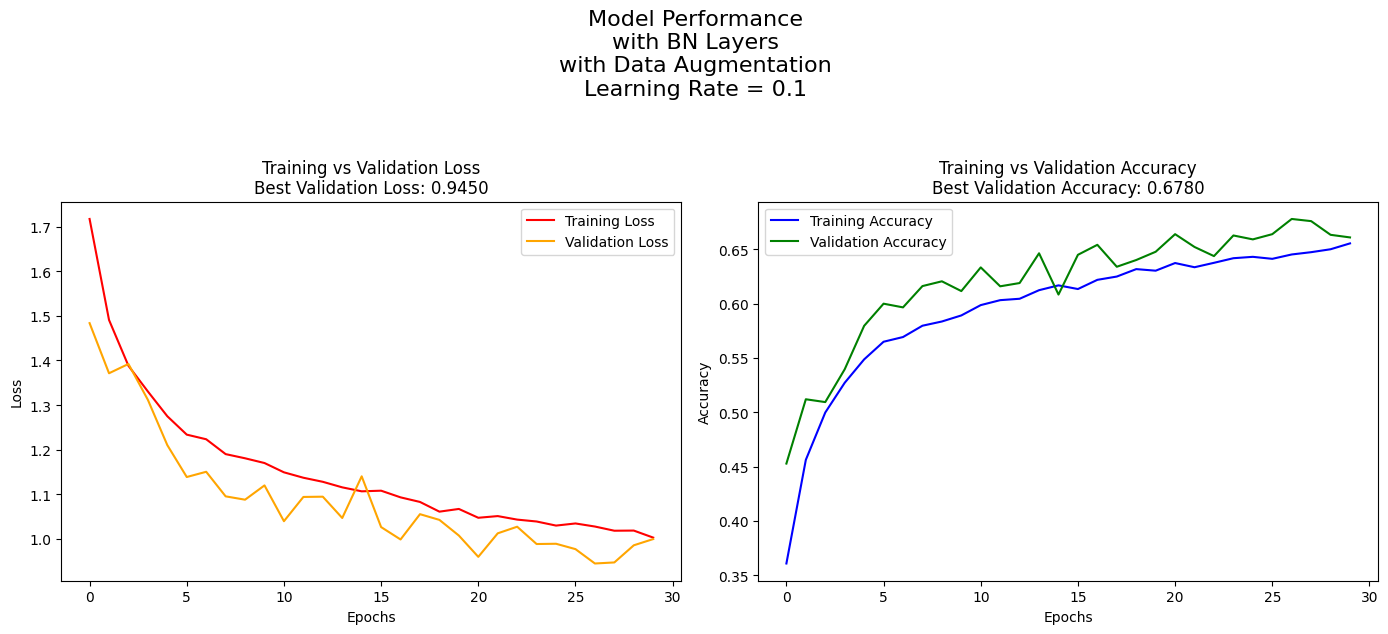

In [26]:
plot_metrics(EPOCHS, train_losses, val_losses, train_accuracies, val_accuracies,
             title=f"Model Performance\nwith BN Layers\nwith Data Augmentation\nLearning Rate = {INITIAL_LR}")

In [27]:
# CNN with Batch Normalization and learning rate = 0.05
# SimpleNN mode;
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Model Definition
net = SimpleNN()
net = net.to(device)

# initial learning rate
INITIAL_LR = 0.05

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(
    net.parameters(),
    lr=INITIAL_LR,
    momentum=MOMENTUM,
    weight_decay=REG
)

# some hyperparameters
# total number of training epochs
EPOCHS = 30
DECAY_EPOCHS = 10
DECAY = 1 # without decay

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# Lists to store accuracy values
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    #######################
    # your code here
    # switch to train mode
    net.train()
    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        train_loss += loss.item()

        # count the number of correctly predicted samples in the current batch
        max_values, predicted = outputs.max(1)
        total_examples += targets.size(0)
        correct_examples += (predicted == targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_accuracies.append(avg_acc)
    train_losses.append(avg_loss)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" % current_learning_rate)


    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

            # count the number of correctly predicted samples in the current batch
            max_values, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += (predicted == targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    val_accuracies.append(avg_acc)
    val_losses.append(avg_loss)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")
        #state = {'state_dict': net.state_dict(),
        #         'epoch': i,
        #         'lr': current_learning_rate}
        #torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")


==> Training starts!
Epoch 0:
Training loss: 1.6740, Training accuracy: 0.3777
Validation loss: 1.4233, Validation accuracy: 0.4834

Epoch 1:
Training loss: 1.4160, Training accuracy: 0.4863
Validation loss: 1.2661, Validation accuracy: 0.5376

Epoch 2:
Training loss: 1.3227, Training accuracy: 0.5246
Validation loss: 1.1739, Validation accuracy: 0.5730

Epoch 3:
Training loss: 1.2451, Training accuracy: 0.5549
Validation loss: 1.2001, Validation accuracy: 0.5764

Epoch 4:
Training loss: 1.2052, Training accuracy: 0.5718
Validation loss: 1.1142, Validation accuracy: 0.6116

Epoch 5:
Training loss: 1.1579, Training accuracy: 0.5858
Validation loss: 1.0919, Validation accuracy: 0.6102

Epoch 6:
Training loss: 1.1239, Training accuracy: 0.6004
Validation loss: 1.0508, Validation accuracy: 0.6320

Epoch 7:
Training loss: 1.0993, Training accuracy: 0.6097
Validation loss: 1.0120, Validation accuracy: 0.6380

Epoch 8:
Training loss: 1.0752, Training accuracy: 0.6181
Validation loss: 1.0481, 

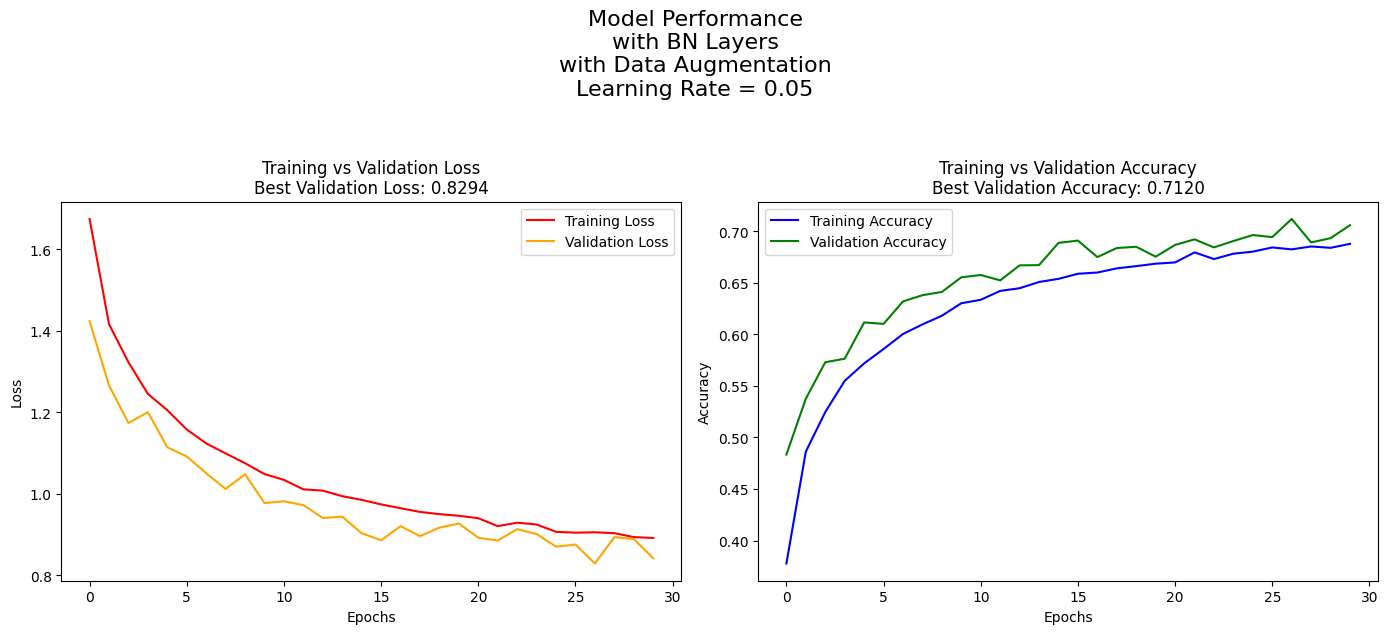

In [28]:
plot_metrics(EPOCHS, train_losses, val_losses, train_accuracies, val_accuracies,
             title=f"Model Performance\nwith BN Layers\nwith Data Augmentation\nLearning Rate = {INITIAL_LR}")

In [29]:
# CNN with Batch Normalization and learning rate = 0.01
# SimpleNN mode;
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Model Definition
net = SimpleNN()
net = net.to(device)

# initial learning rate
INITIAL_LR = 0.01

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(
    net.parameters(),
    lr=INITIAL_LR,
    momentum=MOMENTUM,
    weight_decay=REG
)

# some hyperparameters
# total number of training epochs
EPOCHS = 30
DECAY_EPOCHS = 10
DECAY = 1 # without decay

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# Lists to store accuracy values
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    #######################
    # your code here
    # switch to train mode
    net.train()
    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        train_loss += loss.item()

        # count the number of correctly predicted samples in the current batch
        max_values, predicted = outputs.max(1)
        total_examples += targets.size(0)
        correct_examples += (predicted == targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_accuracies.append(avg_acc)
    train_losses.append(avg_loss)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" % current_learning_rate)


    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

            # count the number of correctly predicted samples in the current batch
            max_values, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += (predicted == targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    val_accuracies.append(avg_acc)
    val_losses.append(avg_loss)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")
        #state = {'state_dict': net.state_dict(),
        #         'epoch': i,
        #         'lr': current_learning_rate}
        #torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")


==> Training starts!
Epoch 0:
Training loss: 1.7349, Training accuracy: 0.3517
Validation loss: 1.4316, Validation accuracy: 0.4772

Epoch 1:
Training loss: 1.4272, Training accuracy: 0.4792
Validation loss: 1.2412, Validation accuracy: 0.5512

Epoch 2:
Training loss: 1.3113, Training accuracy: 0.5272
Validation loss: 1.2695, Validation accuracy: 0.5326

Epoch 3:
Training loss: 1.2292, Training accuracy: 0.5572
Validation loss: 1.0814, Validation accuracy: 0.6100

Epoch 4:
Training loss: 1.1811, Training accuracy: 0.5764
Validation loss: 1.1724, Validation accuracy: 0.5970

Epoch 5:
Training loss: 1.1359, Training accuracy: 0.5950
Validation loss: 1.0048, Validation accuracy: 0.6448

Epoch 6:
Training loss: 1.0981, Training accuracy: 0.6073
Validation loss: 1.0328, Validation accuracy: 0.6254

Epoch 7:
Training loss: 1.0644, Training accuracy: 0.6236
Validation loss: 0.9894, Validation accuracy: 0.6472

Epoch 8:
Training loss: 1.0399, Training accuracy: 0.6341
Validation loss: 0.9627, 

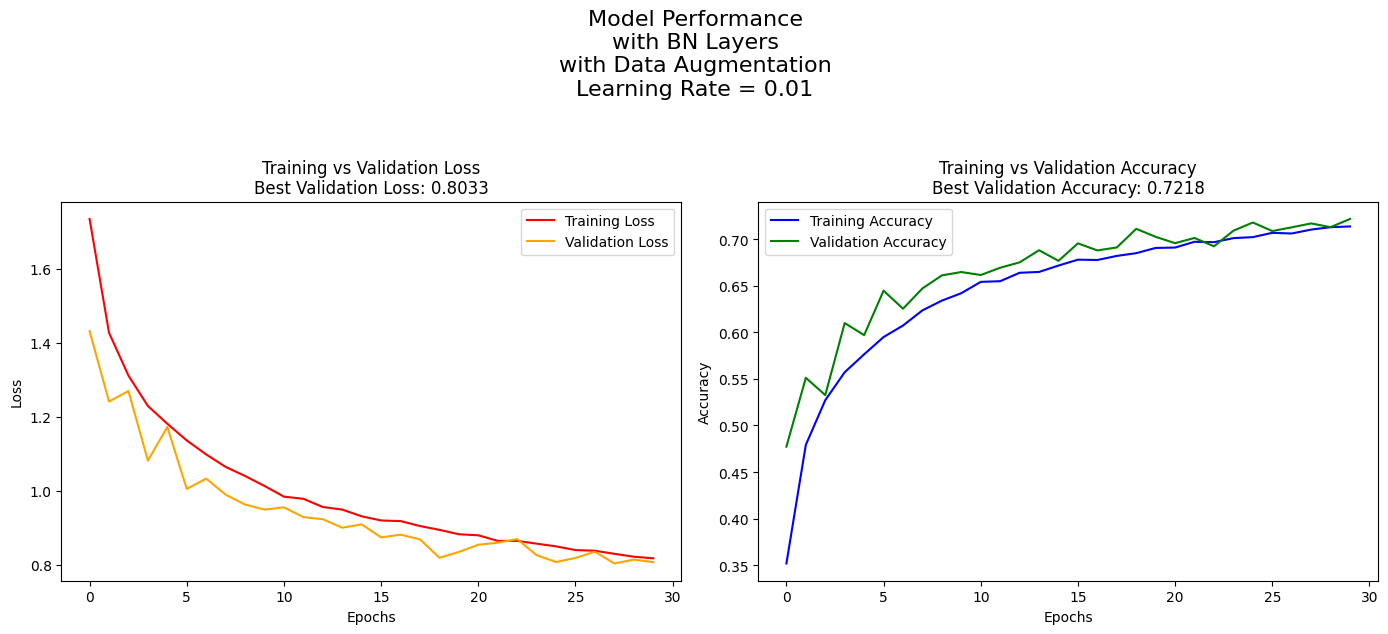

In [30]:
plot_metrics(EPOCHS, train_losses, val_losses, train_accuracies, val_accuracies,
             title=f"Model Performance\nwith BN Layers\nwith Data Augmentation\nLearning Rate = {INITIAL_LR}")

In [31]:
# CNN with Batch Normalization and learning rate = 0.005
# SimpleNN mode;
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Model Definition
net = SimpleNN()
net = net.to(device)

# initial learning rate
INITIAL_LR = 0.005

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(
    net.parameters(),
    lr=INITIAL_LR,
    momentum=MOMENTUM,
    weight_decay=REG
)

# some hyperparameters
# total number of training epochs
EPOCHS = 30
DECAY_EPOCHS = 10
DECAY = 1 # without decay

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# Lists to store accuracy values
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    #######################
    # your code here
    # switch to train mode
    net.train()
    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        train_loss += loss.item()

        # count the number of correctly predicted samples in the current batch
        max_values, predicted = outputs.max(1)
        total_examples += targets.size(0)
        correct_examples += (predicted == targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_accuracies.append(avg_acc)
    train_losses.append(avg_loss)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" % current_learning_rate)


    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

            # count the number of correctly predicted samples in the current batch
            max_values, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += (predicted == targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    val_accuracies.append(avg_acc)
    val_losses.append(avg_loss)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")
        #state = {'state_dict': net.state_dict(),
        #         'epoch': i,
        #         'lr': current_learning_rate}
        #torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")


==> Training starts!
Epoch 0:
Training loss: 1.8659, Training accuracy: 0.3065
Validation loss: 1.5266, Validation accuracy: 0.4376

Epoch 1:
Training loss: 1.5106, Training accuracy: 0.4402
Validation loss: 1.3691, Validation accuracy: 0.4954

Epoch 2:
Training loss: 1.4079, Training accuracy: 0.4868
Validation loss: 1.2723, Validation accuracy: 0.5314

Epoch 3:
Training loss: 1.3281, Training accuracy: 0.5241
Validation loss: 1.2263, Validation accuracy: 0.5576

Epoch 4:
Training loss: 1.2661, Training accuracy: 0.5434
Validation loss: 1.1490, Validation accuracy: 0.5834

Epoch 5:
Training loss: 1.2226, Training accuracy: 0.5650
Validation loss: 1.1479, Validation accuracy: 0.5860

Epoch 6:
Training loss: 1.1936, Training accuracy: 0.5749
Validation loss: 1.1267, Validation accuracy: 0.5908

Epoch 7:
Training loss: 1.1553, Training accuracy: 0.5877
Validation loss: 1.1390, Validation accuracy: 0.5900

Epoch 8:
Training loss: 1.1332, Training accuracy: 0.5953
Validation loss: 1.0499, 

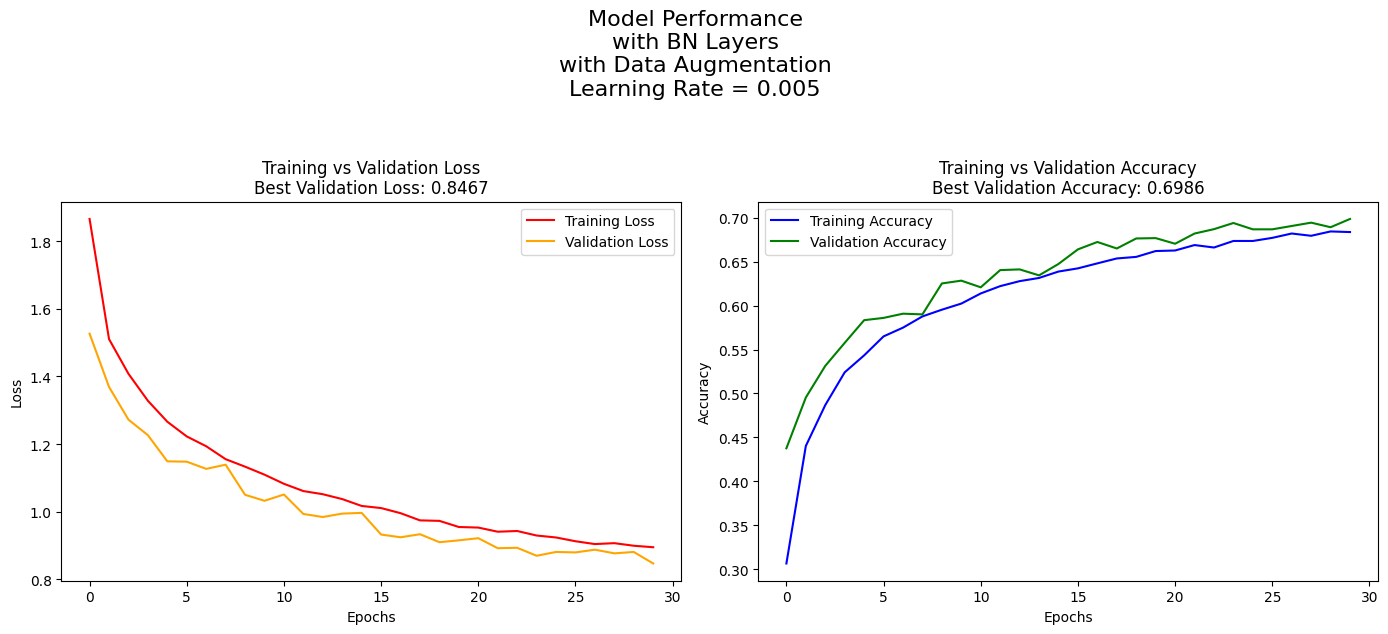

In [32]:
plot_metrics(EPOCHS, train_losses, val_losses, train_accuracies, val_accuracies,
             title=f"Model Performance\nwith BN Layers\nwith Data Augmentation\nLearning Rate = {INITIAL_LR}")

In [33]:
# CNN with Batch Normalization and learning rate = 0.001
# SimpleNN mode;
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Model Definition
net = SimpleNN()
net = net.to(device)

# initial learning rate
INITIAL_LR = 0.001

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(
    net.parameters(),
    lr=INITIAL_LR,
    momentum=MOMENTUM,
    weight_decay=REG
)

# some hyperparameters
# total number of training epochs
EPOCHS = 30
DECAY_EPOCHS = 10
DECAY = 1 # without decay

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# Lists to store accuracy values
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    #######################
    # your code here
    # switch to train mode
    net.train()
    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        train_loss += loss.item()

        # count the number of correctly predicted samples in the current batch
        max_values, predicted = outputs.max(1)
        total_examples += targets.size(0)
        correct_examples += (predicted == targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_accuracies.append(avg_acc)
    train_losses.append(avg_loss)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" % current_learning_rate)


    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

            # count the number of correctly predicted samples in the current batch
            max_values, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += (predicted == targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    val_accuracies.append(avg_acc)
    val_losses.append(avg_loss)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")
        #state = {'state_dict': net.state_dict(),
        #         'epoch': i,
        #         'lr': current_learning_rate}
        #torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")


==> Training starts!
Epoch 0:
Training loss: 2.2149, Training accuracy: 0.1985
Validation loss: 2.0418, Validation accuracy: 0.2484

Epoch 1:
Training loss: 1.8798, Training accuracy: 0.3098
Validation loss: 1.7173, Validation accuracy: 0.3668

Epoch 2:
Training loss: 1.7072, Training accuracy: 0.3653
Validation loss: 1.5953, Validation accuracy: 0.4150

Epoch 3:
Training loss: 1.5997, Training accuracy: 0.4074
Validation loss: 1.5078, Validation accuracy: 0.4410

Epoch 4:
Training loss: 1.5051, Training accuracy: 0.4488
Validation loss: 1.4095, Validation accuracy: 0.4794

Epoch 5:
Training loss: 1.4362, Training accuracy: 0.4785
Validation loss: 1.3460, Validation accuracy: 0.5048

Epoch 6:
Training loss: 1.3905, Training accuracy: 0.4975
Validation loss: 1.3135, Validation accuracy: 0.5236

Epoch 7:
Training loss: 1.3531, Training accuracy: 0.5129
Validation loss: 1.2913, Validation accuracy: 0.5324

Epoch 8:
Training loss: 1.3292, Training accuracy: 0.5227
Validation loss: 1.2477, 

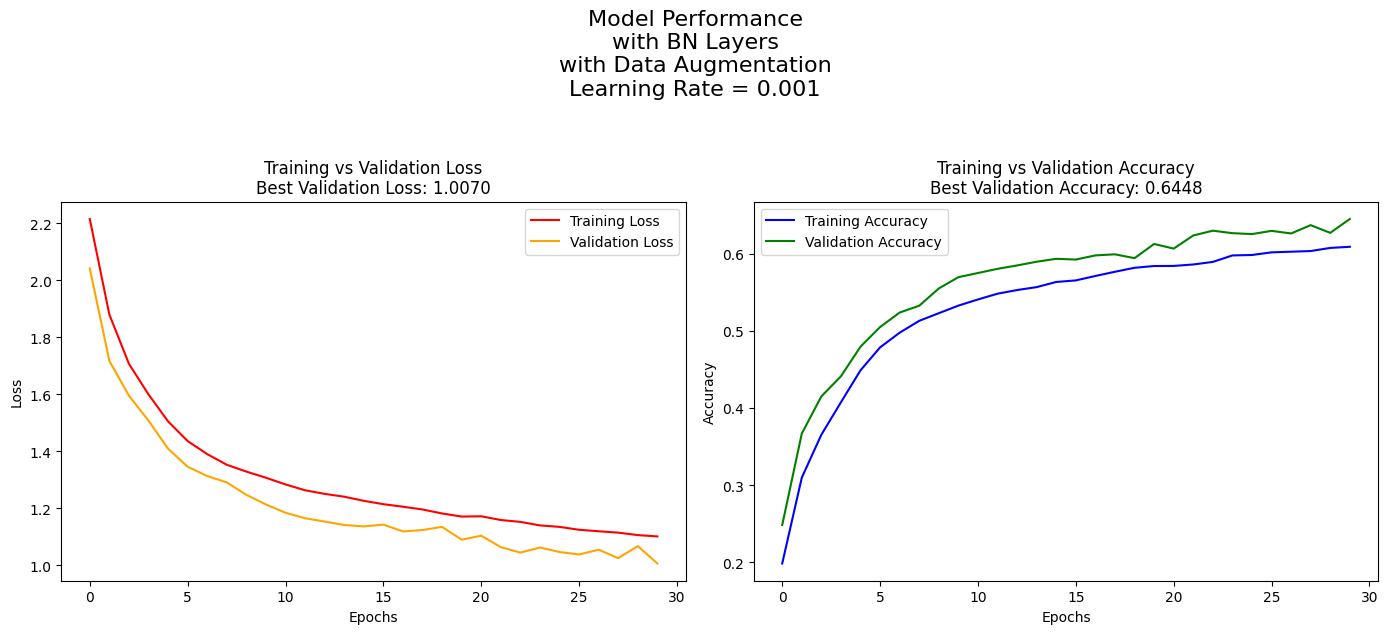

In [34]:
plot_metrics(EPOCHS, train_losses, val_losses, train_accuracies, val_accuracies,
             title=f"Model Performance\nwith BN Layers\nwith Data Augmentation\nLearning Rate = {INITIAL_LR}")

ii.	(7 pts) Use different L2 regularization strengths of 1e-2, 1e-3, 1e-4, 1e-5, and 0.0 to see how the L2 regularization strength affects the model performance. In this problem use a learning rate of
0.01. Report the results for each regularization strength value. What did you expect? Are the results what you expected?


In [35]:
# CNN with Batch Normalization and learning rate = 0.01,
# L2 regularization strengths of 1e-2

# SimpleNN mode;
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Model Definition
net = SimpleNN()
net = net.to(device)

# initial learning rate
INITIAL_LR = 0.01

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-2

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(
    net.parameters(),
    lr=INITIAL_LR,
    momentum=MOMENTUM,
    weight_decay=REG
)

# some hyperparameters
# total number of training epochs
EPOCHS = 30
DECAY_EPOCHS = 10
DECAY = 1 # without decay

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# Lists to store accuracy values
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    #######################
    # your code here
    # switch to train mode
    net.train()
    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        train_loss += loss.item()

        # count the number of correctly predicted samples in the current batch
        max_values, predicted = outputs.max(1)
        total_examples += targets.size(0)
        correct_examples += (predicted == targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_accuracies.append(avg_acc)
    train_losses.append(avg_loss)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" % current_learning_rate)


    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

            # count the number of correctly predicted samples in the current batch
            max_values, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += (predicted == targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    val_accuracies.append(avg_acc)
    val_losses.append(avg_loss)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")
        #state = {'state_dict': net.state_dict(),
        #         'epoch': i,
        #         'lr': current_learning_rate}
        #torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")


==> Training starts!
Epoch 0:
Training loss: 1.7898, Training accuracy: 0.3348
Validation loss: 1.4877, Validation accuracy: 0.4472

Epoch 1:
Training loss: 1.4711, Training accuracy: 0.4613
Validation loss: 1.3177, Validation accuracy: 0.5220

Epoch 2:
Training loss: 1.3973, Training accuracy: 0.4953
Validation loss: 1.2918, Validation accuracy: 0.5290

Epoch 3:
Training loss: 1.3419, Training accuracy: 0.5164
Validation loss: 1.2291, Validation accuracy: 0.5588

Epoch 4:
Training loss: 1.3207, Training accuracy: 0.5244
Validation loss: 1.2264, Validation accuracy: 0.5578

Epoch 5:
Training loss: 1.2870, Training accuracy: 0.5402
Validation loss: 1.2125, Validation accuracy: 0.5740

Epoch 6:
Training loss: 1.2756, Training accuracy: 0.5435
Validation loss: 1.1562, Validation accuracy: 0.5884

Epoch 7:
Training loss: 1.2541, Training accuracy: 0.5548
Validation loss: 1.2619, Validation accuracy: 0.5530

Epoch 8:
Training loss: 1.2352, Training accuracy: 0.5577
Validation loss: 1.1753, 

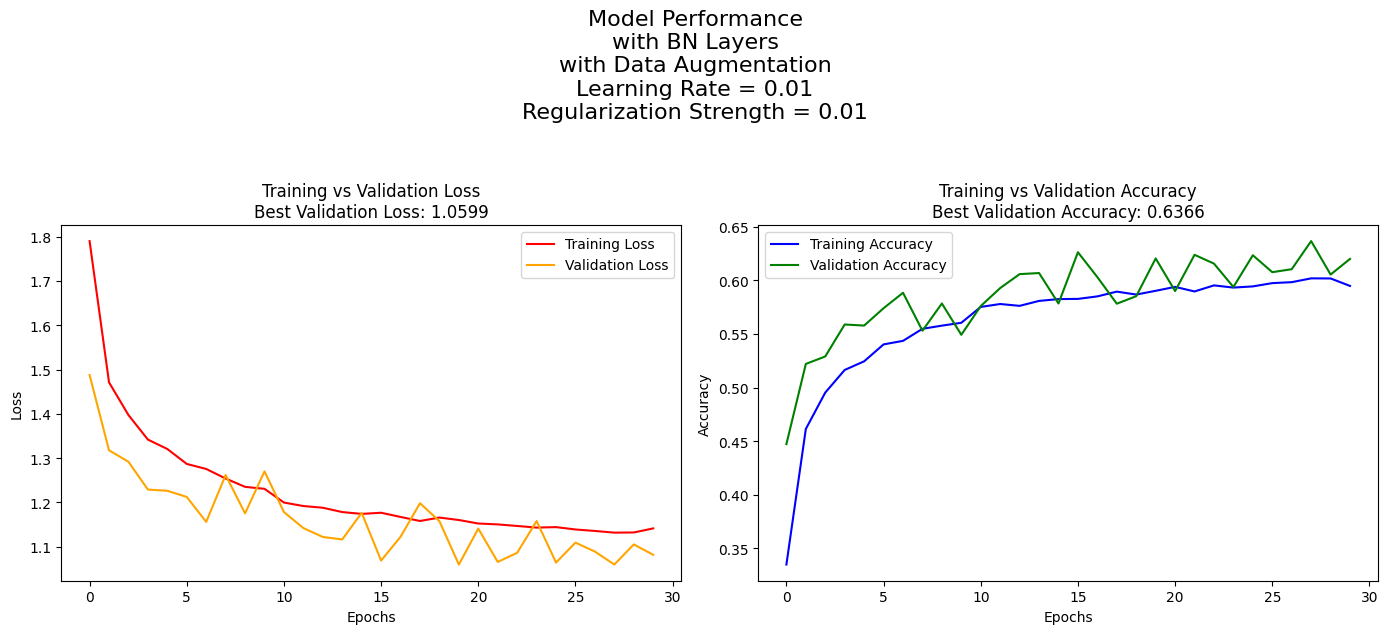

In [36]:
plot_metrics(EPOCHS, train_losses, val_losses, train_accuracies, val_accuracies,
             title=f"Model Performance\nwith BN Layers\nwith Data Augmentation\nLearning Rate = {INITIAL_LR}\nRegularization Strength = {REG}")


In [37]:
# CNN with Batch Normalization and learning rate = 0.01,
# L2 regularization strengths of 1e-3

# SimpleNN mode;
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Model Definition
net = SimpleNN()
net = net.to(device)

# initial learning rate
INITIAL_LR = 0.01

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-3

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(
    net.parameters(),
    lr=INITIAL_LR,
    momentum=MOMENTUM,
    weight_decay=REG
)

# some hyperparameters
# total number of training epochs
EPOCHS = 30
DECAY_EPOCHS = 10
DECAY = 1 # without decay

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# Lists to store accuracy values
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    #######################
    # your code here
    # switch to train mode
    net.train()
    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        train_loss += loss.item()

        # count the number of correctly predicted samples in the current batch
        max_values, predicted = outputs.max(1)
        total_examples += targets.size(0)
        correct_examples += (predicted == targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_accuracies.append(avg_acc)
    train_losses.append(avg_loss)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" % current_learning_rate)


    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

            # count the number of correctly predicted samples in the current batch
            max_values, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += (predicted == targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    val_accuracies.append(avg_acc)
    val_losses.append(avg_loss)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")
        #state = {'state_dict': net.state_dict(),
        #         'epoch': i,
        #         'lr': current_learning_rate}
        #torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")


==> Training starts!
Epoch 0:
Training loss: 1.7780, Training accuracy: 0.3331
Validation loss: 1.4815, Validation accuracy: 0.4520

Epoch 1:
Training loss: 1.4838, Training accuracy: 0.4561
Validation loss: 1.3200, Validation accuracy: 0.5250

Epoch 2:
Training loss: 1.3553, Training accuracy: 0.5084
Validation loss: 1.2171, Validation accuracy: 0.5654

Epoch 3:
Training loss: 1.2655, Training accuracy: 0.5417
Validation loss: 1.1631, Validation accuracy: 0.5808

Epoch 4:
Training loss: 1.1994, Training accuracy: 0.5676
Validation loss: 1.1336, Validation accuracy: 0.5972

Epoch 5:
Training loss: 1.1657, Training accuracy: 0.5834
Validation loss: 1.0827, Validation accuracy: 0.6134

Epoch 6:
Training loss: 1.1277, Training accuracy: 0.5978
Validation loss: 1.0684, Validation accuracy: 0.6178

Epoch 7:
Training loss: 1.1062, Training accuracy: 0.6060
Validation loss: 1.0184, Validation accuracy: 0.6456

Epoch 8:
Training loss: 1.0693, Training accuracy: 0.6200
Validation loss: 1.0687, 

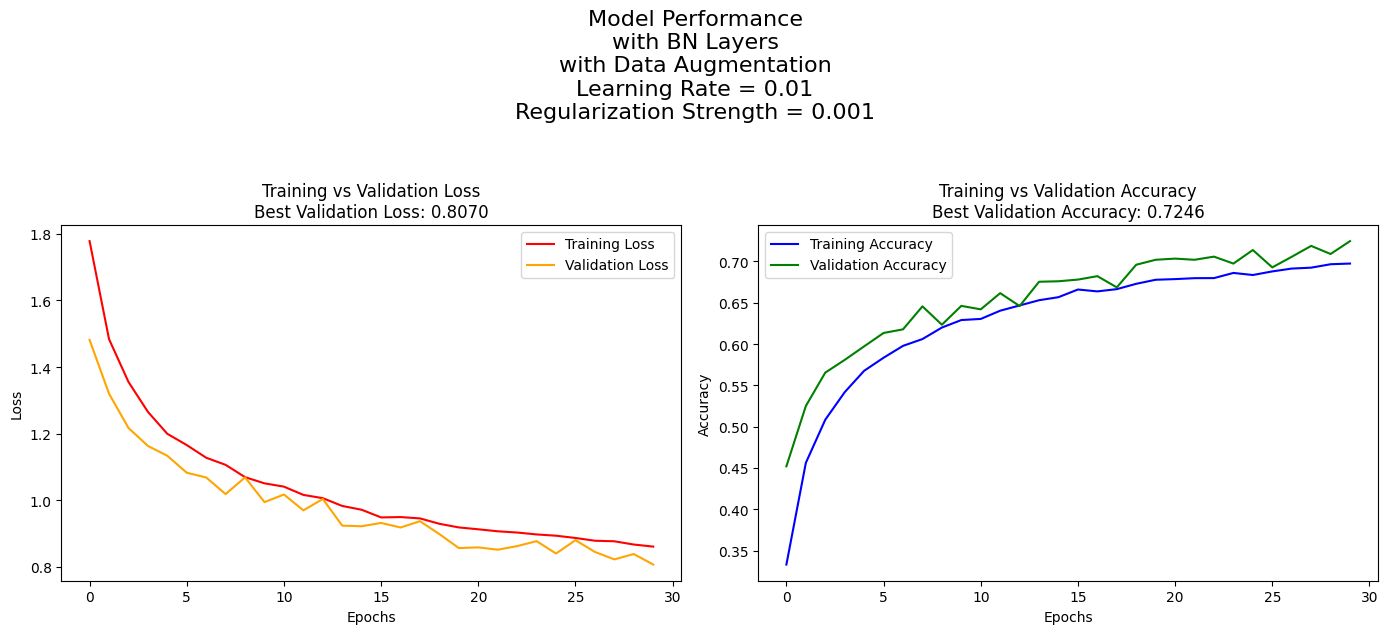

In [38]:
plot_metrics(EPOCHS, train_losses, val_losses, train_accuracies, val_accuracies,
             title=f"Model Performance\nwith BN Layers\nwith Data Augmentation\nLearning Rate = {INITIAL_LR}\nRegularization Strength = {REG}")

In [39]:
# CNN with Batch Normalization and learning rate = 0.01,
# L2 regularization strengths of 1e-4

# SimpleNN mode;
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Model Definition
net = SimpleNN()
net = net.to(device)

# initial learning rate
INITIAL_LR = 0.01

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(
    net.parameters(),
    lr=INITIAL_LR,
    momentum=MOMENTUM,
    weight_decay=REG
)

# some hyperparameters
# total number of training epochs
EPOCHS = 30
DECAY_EPOCHS = 10
DECAY = 1 # without decay

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# Lists to store accuracy values
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    #######################
    # your code here
    # switch to train mode
    net.train()
    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        train_loss += loss.item()

        # count the number of correctly predicted samples in the current batch
        max_values, predicted = outputs.max(1)
        total_examples += targets.size(0)
        correct_examples += (predicted == targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_accuracies.append(avg_acc)
    train_losses.append(avg_loss)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" % current_learning_rate)


    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

            # count the number of correctly predicted samples in the current batch
            max_values, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += (predicted == targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    val_accuracies.append(avg_acc)
    val_losses.append(avg_loss)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")
        #state = {'state_dict': net.state_dict(),
        #         'epoch': i,
        #         'lr': current_learning_rate}
        #torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")
weights_l2 = {name: param.detach().cpu().numpy() for name, param in net.named_parameters() if 'weight' in name}

==> Training starts!
Epoch 0:
Training loss: 1.7758, Training accuracy: 0.3412
Validation loss: 1.5106, Validation accuracy: 0.4496

Epoch 1:
Training loss: 1.4561, Training accuracy: 0.4687
Validation loss: 1.3185, Validation accuracy: 0.5264

Epoch 2:
Training loss: 1.3376, Training accuracy: 0.5179
Validation loss: 1.1690, Validation accuracy: 0.5856

Epoch 3:
Training loss: 1.2596, Training accuracy: 0.5482
Validation loss: 1.1522, Validation accuracy: 0.5894

Epoch 4:
Training loss: 1.2031, Training accuracy: 0.5697
Validation loss: 1.1354, Validation accuracy: 0.5988

Epoch 5:
Training loss: 1.1533, Training accuracy: 0.5895
Validation loss: 1.0927, Validation accuracy: 0.6126

Epoch 6:
Training loss: 1.1144, Training accuracy: 0.6057
Validation loss: 1.0169, Validation accuracy: 0.6402

Epoch 7:
Training loss: 1.0822, Training accuracy: 0.6179
Validation loss: 1.0093, Validation accuracy: 0.6444

Epoch 8:
Training loss: 1.0575, Training accuracy: 0.6235
Validation loss: 1.0265, 

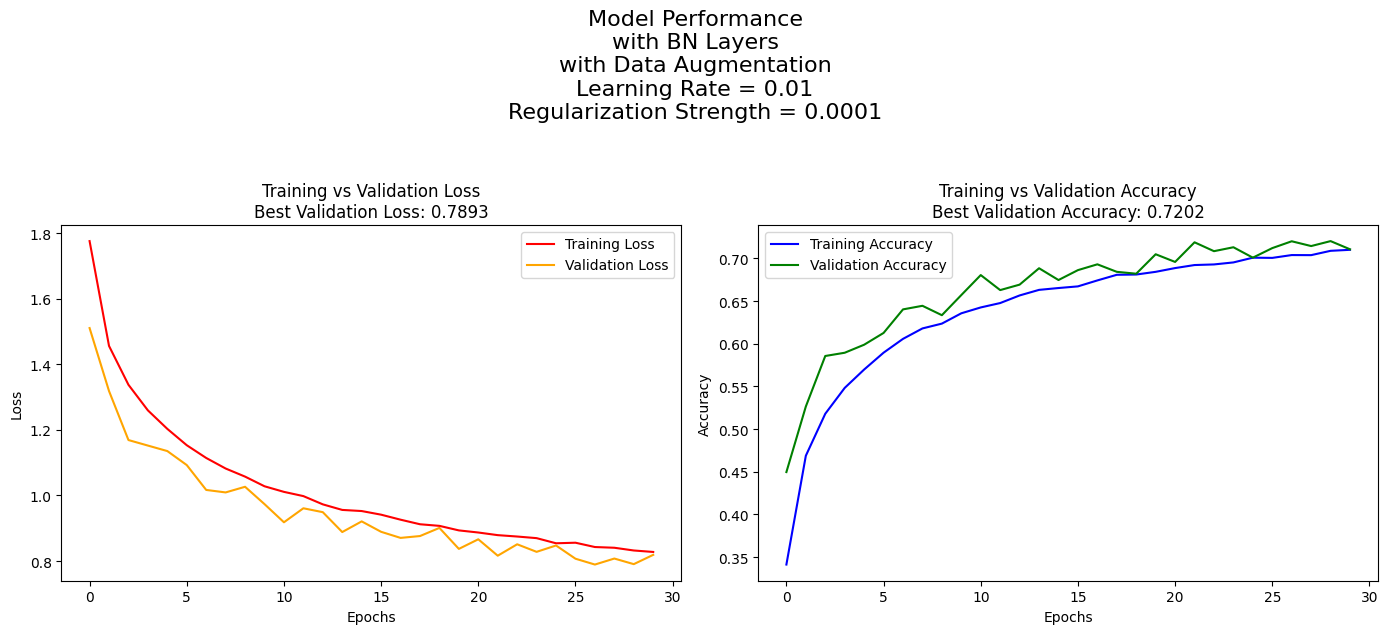

In [40]:
plot_metrics(EPOCHS, train_losses, val_losses, train_accuracies, val_accuracies,
             title=f"Model Performance\nwith BN Layers\nwith Data Augmentation\nLearning Rate = {INITIAL_LR}\nRegularization Strength = {REG}")

In [41]:
# CNN with Batch Normalization and learning rate = 0.01,
# L2 regularization strengths of 1e-5

# SimpleNN mode;
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Model Definition
net = SimpleNN()
net = net.to(device)

# initial learning rate
INITIAL_LR = 0.01

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-5

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(
    net.parameters(),
    lr=INITIAL_LR,
    momentum=MOMENTUM,
    weight_decay=REG
)

# some hyperparameters
# total number of training epochs
EPOCHS = 30
DECAY_EPOCHS = 10
DECAY = 1 # without decay

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# Lists to store accuracy values
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    #######################
    # your code here
    # switch to train mode
    net.train()
    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        train_loss += loss.item()

        # count the number of correctly predicted samples in the current batch
        max_values, predicted = outputs.max(1)
        total_examples += targets.size(0)
        correct_examples += (predicted == targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_accuracies.append(avg_acc)
    train_losses.append(avg_loss)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" % current_learning_rate)


    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

            # count the number of correctly predicted samples in the current batch
            max_values, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += (predicted == targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    val_accuracies.append(avg_acc)
    val_losses.append(avg_loss)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")
        #state = {'state_dict': net.state_dict(),
        #         'epoch': i,
        #         'lr': current_learning_rate}
        #torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")


==> Training starts!
Epoch 0:
Training loss: 1.7839, Training accuracy: 0.3352
Validation loss: 1.4747, Validation accuracy: 0.4546

Epoch 1:
Training loss: 1.4634, Training accuracy: 0.4644
Validation loss: 1.3091, Validation accuracy: 0.5330

Epoch 2:
Training loss: 1.3612, Training accuracy: 0.5075
Validation loss: 1.2468, Validation accuracy: 0.5558

Epoch 3:
Training loss: 1.2907, Training accuracy: 0.5345
Validation loss: 1.2201, Validation accuracy: 0.5620

Epoch 4:
Training loss: 1.2280, Training accuracy: 0.5597
Validation loss: 1.1088, Validation accuracy: 0.6048

Epoch 5:
Training loss: 1.1916, Training accuracy: 0.5728
Validation loss: 1.1179, Validation accuracy: 0.6040

Epoch 6:
Training loss: 1.1439, Training accuracy: 0.5908
Validation loss: 1.0766, Validation accuracy: 0.6158

Epoch 7:
Training loss: 1.1167, Training accuracy: 0.6004
Validation loss: 1.0909, Validation accuracy: 0.6124

Epoch 8:
Training loss: 1.0872, Training accuracy: 0.6116
Validation loss: 1.0231, 

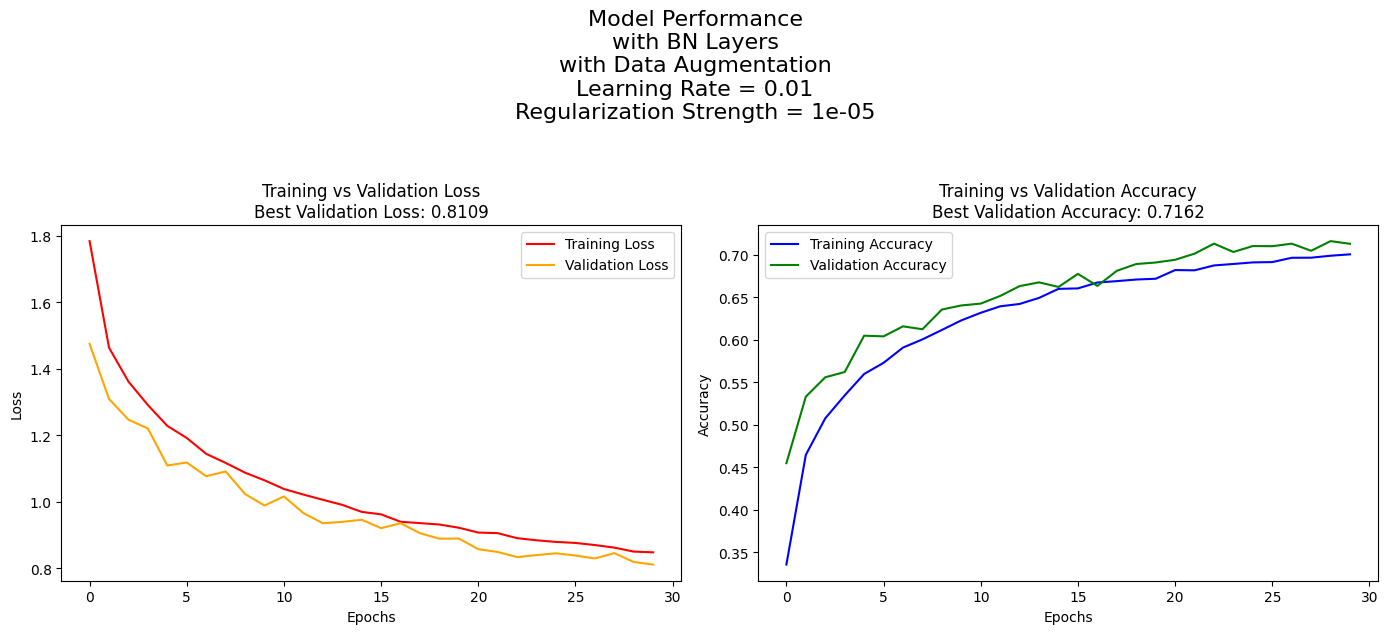

In [42]:
plot_metrics(EPOCHS, train_losses, val_losses, train_accuracies, val_accuracies,
             title=f"Model Performance\nwith BN Layers\nwith Data Augmentation\nLearning Rate = {INITIAL_LR}\nRegularization Strength = {REG}")

In [9]:
# CNN with Batch Normalization and learning rate = 0.01,
# L2 regularization strengths of 0.0

# SimpleNN mode;
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Model Definition
net = SimpleNN()
net = net.to(device)

# initial learning rate
INITIAL_LR = 0.01

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 0.0

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(
    net.parameters(),
    lr=INITIAL_LR,
    momentum=MOMENTUM,
    weight_decay=REG
)

# some hyperparameters
# total number of training epochs
EPOCHS = 30
DECAY_EPOCHS = 10
DECAY = 1 # without decay

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# Lists to store accuracy values
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    #######################
    # your code here
    # switch to train mode
    net.train()
    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        train_loss += loss.item()

        # count the number of correctly predicted samples in the current batch
        max_values, predicted = outputs.max(1)
        total_examples += targets.size(0)
        correct_examples += (predicted == targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_accuracies.append(avg_acc)
    train_losses.append(avg_loss)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" % current_learning_rate)


    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

            # count the number of correctly predicted samples in the current batch
            max_values, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += (predicted == targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    val_accuracies.append(avg_acc)
    val_losses.append(avg_loss)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")
        #state = {'state_dict': net.state_dict(),
        #         'epoch': i,
        #         'lr': current_learning_rate}
        #torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")


==> Training starts!
Epoch 0:
Training loss: 1.7535, Training accuracy: 0.3443
Validation loss: 1.4687, Validation accuracy: 0.4574

Epoch 1:
Training loss: 1.4408, Training accuracy: 0.4722
Validation loss: 1.2502, Validation accuracy: 0.5566

Epoch 2:
Training loss: 1.3196, Training accuracy: 0.5231
Validation loss: 1.1910, Validation accuracy: 0.5768

Epoch 3:
Training loss: 1.2441, Training accuracy: 0.5535
Validation loss: 1.1282, Validation accuracy: 0.6012

Epoch 4:
Training loss: 1.1826, Training accuracy: 0.5753
Validation loss: 1.0985, Validation accuracy: 0.6044

Epoch 5:
Training loss: 1.1373, Training accuracy: 0.5941
Validation loss: 1.1033, Validation accuracy: 0.6076

Epoch 6:
Training loss: 1.1051, Training accuracy: 0.6100
Validation loss: 1.0301, Validation accuracy: 0.6366

Epoch 7:
Training loss: 1.0759, Training accuracy: 0.6177
Validation loss: 1.0259, Validation accuracy: 0.6366

Epoch 8:
Training loss: 1.0450, Training accuracy: 0.6293
Validation loss: 0.9743, 

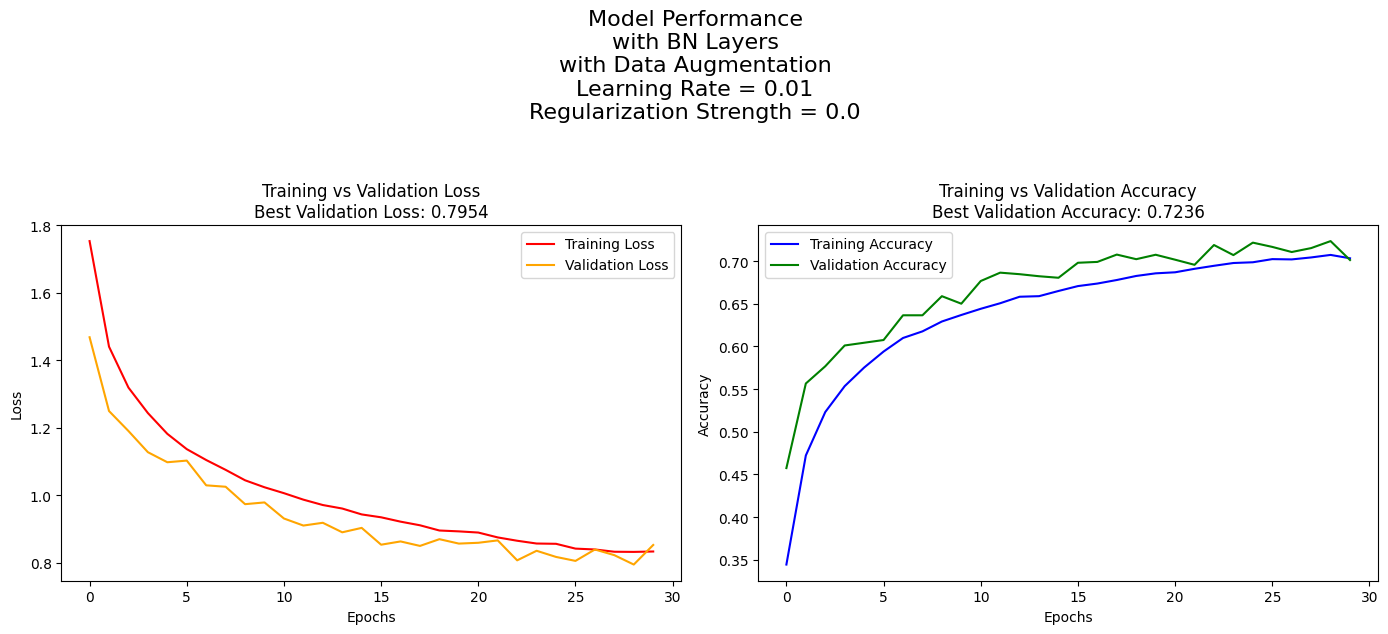

In [10]:
plot_metrics(EPOCHS, train_losses, val_losses, train_accuracies, val_accuracies,
             title=f"Model Performance\nwith BN Layers\nwith Data Augmentation\nLearning Rate = {INITIAL_LR}\nRegularization Strength = {REG}")

iii.	(Bonus, 6 pts) Switch the regularization penalty from L2 penalty to L1 penalty and train with the default hyperparameters. Hint: This means you may not use the weight_decay parameter in PyTorch builtin optimizers, as it does not support L1 regularization. Instead, you need to add L1 penalty as a part of the loss function. Compare the distribution of weight parameters after L1/L2 regularization. Describe your observations, are they what you expected? Why or why not?
Up to now, you shall have an improved training pipeline for CIFAR-10. Remember, you are required to submit simplenn-cifar10-dev.ipynb for Lab (2).

In [43]:
# CNN with Batch Normalization and learning rate = 0.01,
# L2 regularization strengths of 1e-4

# SimpleNN mode;
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Model Definition
net = SimpleNN()
net = net.to(device)

# initial learning rate
INITIAL_LR = 0.01

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4
L1_lambda = REG  # we are using same number

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(
    net.parameters(),
    lr=INITIAL_LR,
    momentum=MOMENTUM,
    #weight_decay=REG. --> USING L1 instead of L2
)

# some hyperparameters
# total number of training epochs
EPOCHS = 30
DECAY_EPOCHS = 10
DECAY = 1 # without decay

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# Lists to store accuracy values
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    #######################
    # your code here
    # switch to train mode
    net.train()
    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # L1 Regularization

        L1_penalty = sum(torch.sum(torch.abs(param)) for param in net.parameters())

        loss += L1_lambda * L1_penalty

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        train_loss += loss.item()

        # count the number of correctly predicted samples in the current batch
        max_values, predicted = outputs.max(1)
        total_examples += targets.size(0)
        correct_examples += (predicted == targets).sum().item()
        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_accuracies.append(avg_acc)
    train_losses.append(avg_loss)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" % current_learning_rate)


    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

            # count the number of correctly predicted samples in the current batch
            max_values, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += (predicted == targets).sum().item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    val_accuracies.append(avg_acc)
    val_losses.append(avg_loss)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        #if not os.path.exists(CHECKPOINT_FOLDER):
        #    os.makedirs(CHECKPOINT_FOLDER)
        #print("Saving ...")
        #state = {'state_dict': net.state_dict(),
        #         'epoch': i,
        #         'lr': current_learning_rate}
        #torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

weights_l1 = {name: param.detach().cpu().numpy() for name, param in net.named_parameters() if 'weight' in name}


==> Training starts!
Epoch 0:
Training loss: 1.9617, Training accuracy: 0.3390
Validation loss: 1.4463, Validation accuracy: 0.4638

Epoch 1:
Training loss: 1.6432, Training accuracy: 0.4668
Validation loss: 1.3144, Validation accuracy: 0.5238

Epoch 2:
Training loss: 1.5283, Training accuracy: 0.5135
Validation loss: 1.2017, Validation accuracy: 0.5658

Epoch 3:
Training loss: 1.4391, Training accuracy: 0.5447
Validation loss: 1.1406, Validation accuracy: 0.5894

Epoch 4:
Training loss: 1.3715, Training accuracy: 0.5735
Validation loss: 1.0811, Validation accuracy: 0.6160

Epoch 5:
Training loss: 1.3289, Training accuracy: 0.5885
Validation loss: 1.0236, Validation accuracy: 0.6336

Epoch 6:
Training loss: 1.2957, Training accuracy: 0.6012
Validation loss: 1.0906, Validation accuracy: 0.6144

Epoch 7:
Training loss: 1.2711, Training accuracy: 0.6100
Validation loss: 0.9913, Validation accuracy: 0.6510

Epoch 8:
Training loss: 1.2577, Training accuracy: 0.6159
Validation loss: 1.0051, 

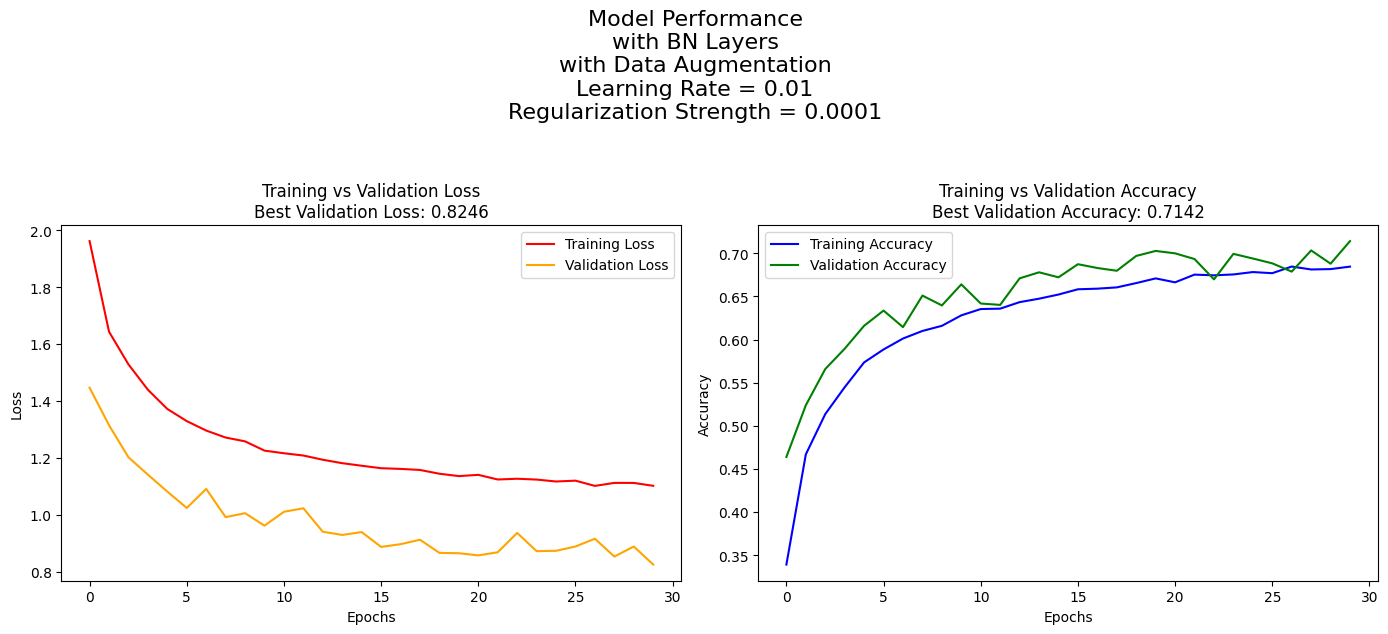

In [44]:
plot_metrics(EPOCHS, train_losses, val_losses, train_accuracies, val_accuracies,
             title=f"Model Performance\nwith BN Layers\nwith Data Augmentation\nLearning Rate = {INITIAL_LR}\nRegularization Strength = {REG}")

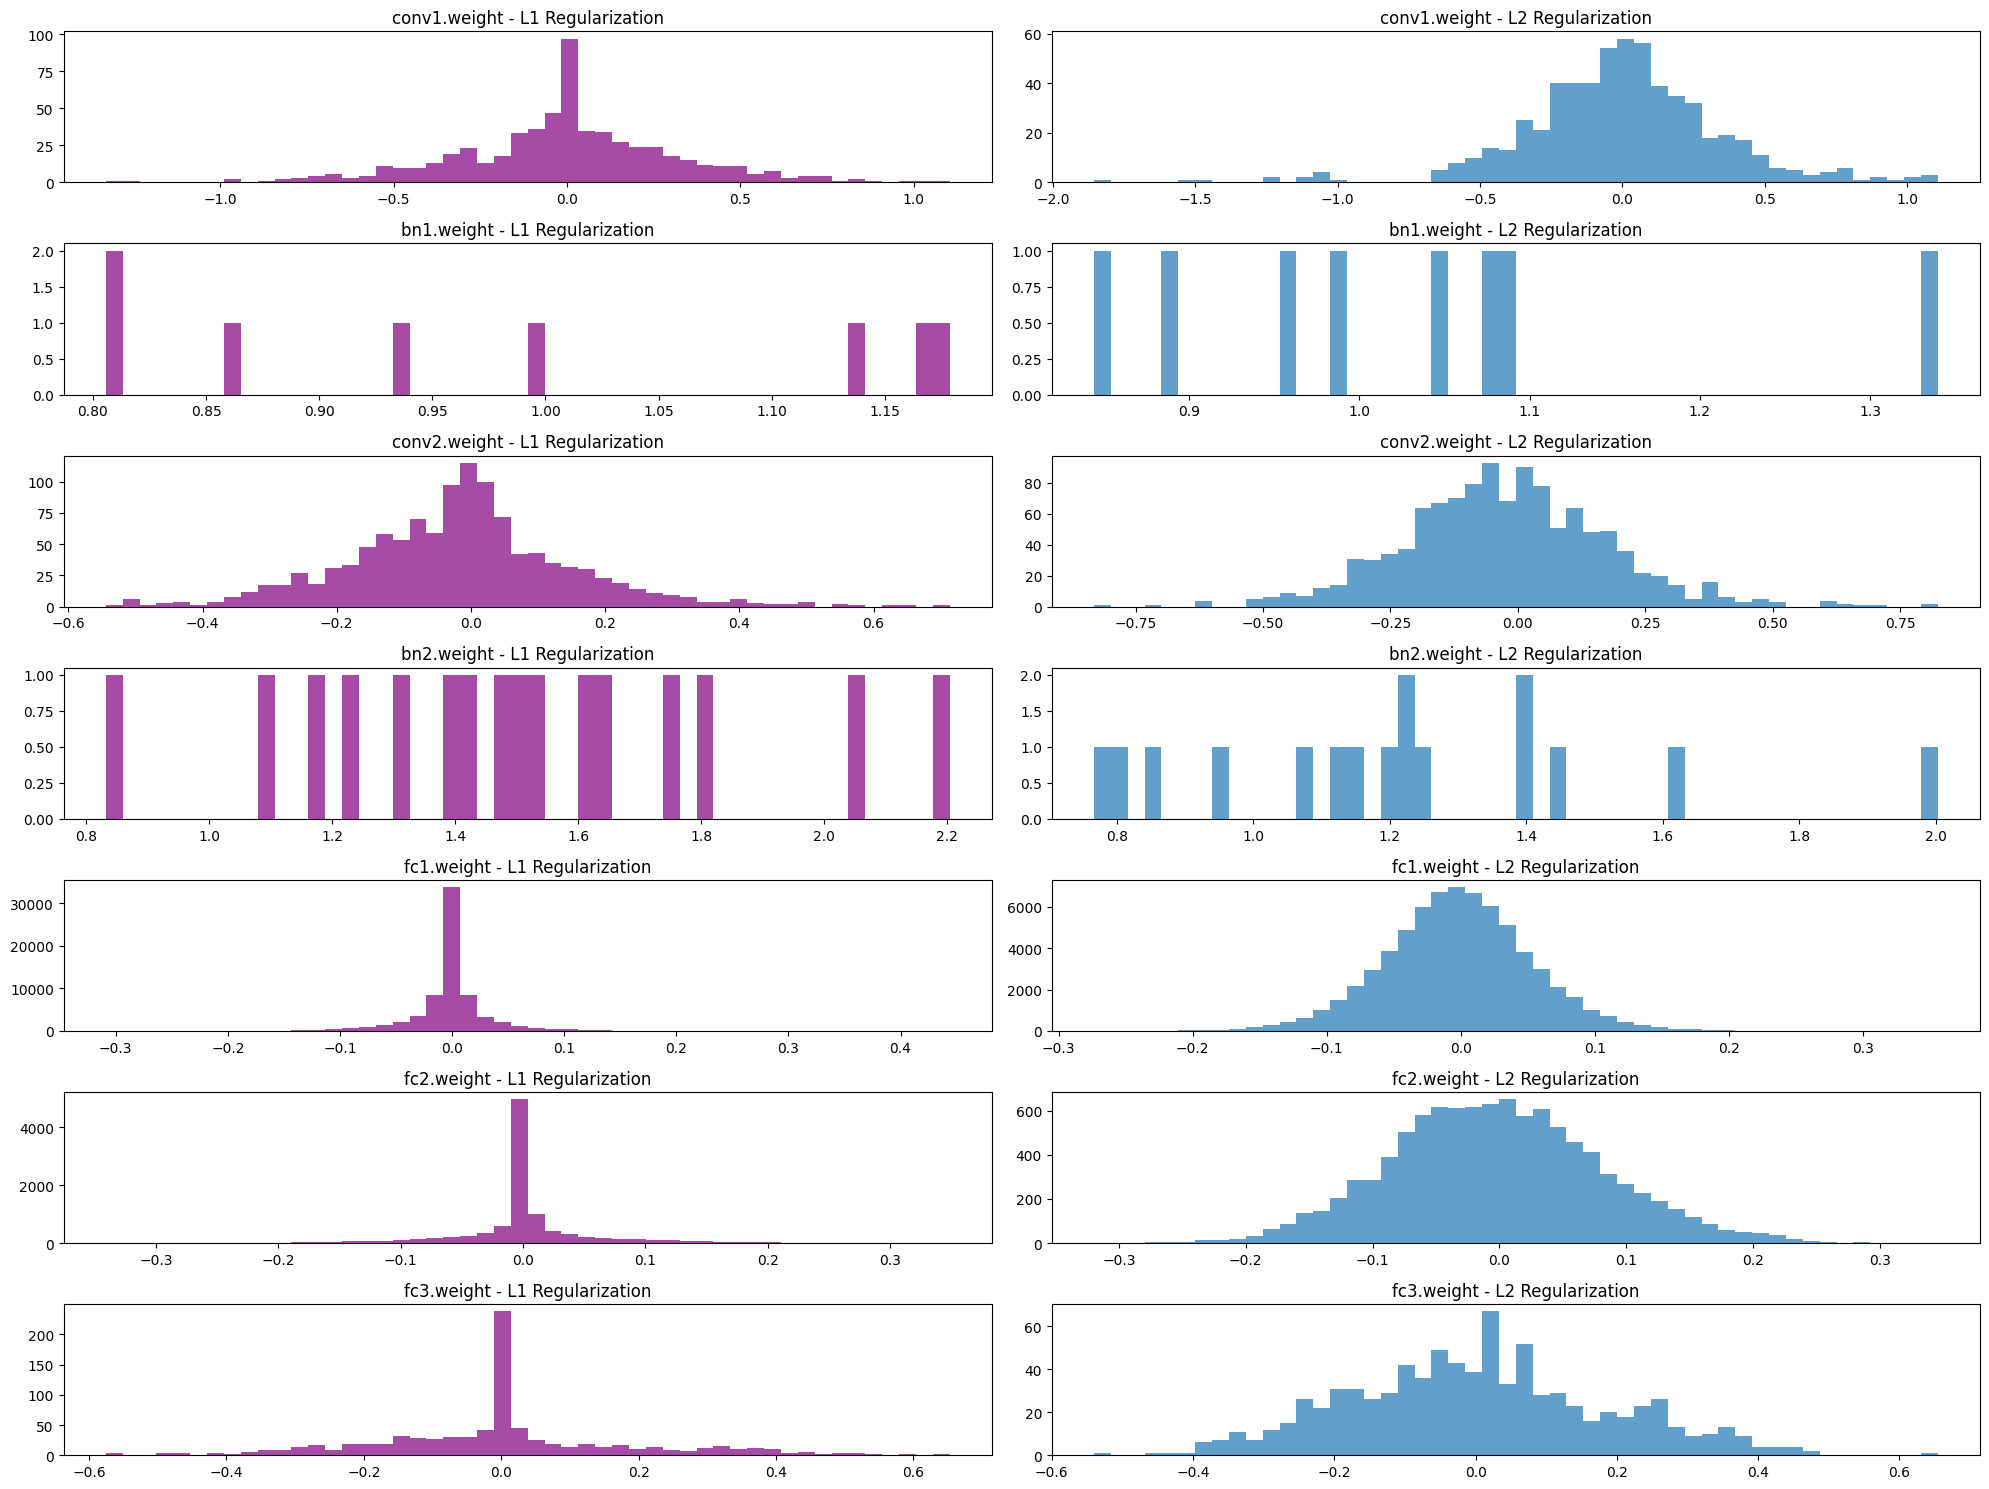

In [45]:
def plot_weight_comparison(weights_l1, weights_l2, title_l1, title_l2):
    plt.figure(figsize=(20, 15))

    for i, ((name_l1, w_l1), (name_l2, w_l2)) in enumerate(zip(weights_l1.items(), weights_l2.items())):
        # L1
        plt.subplot(len(weights_l1), 2, 2*i+1)
        plt.hist(w_l1.flatten(), bins=50, alpha=0.7, color='purple')
        plt.title(f"{name_l1} - {title_l1}")

        # L2
        plt.subplot(len(weights_l2), 2, 2*i+2)
        plt.hist(w_l2.flatten(), bins=50, alpha=0.7 )
        plt.title(f"{name_l2} - {title_l2}")

    plt.tight_layout()
    plt.show()

plot_weight_comparison(weights_l1, weights_l2, "L1 Regularization", "L2 Regularization")
